# make_grid:
## Make high res grid, choose either GEBCO_v2023 or bedmachine v3
### Version id:
### bedmachine v3
### adding last smooth as a smooth of the WCT, not the bathy.

In [1]:

run ='amery'
vers='v2km'
plotting = True

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import xarray as xr
import scipy.io as sio
from scipy.interpolate import griddata
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks



out_path = os.path.join(data_dir,'proc',run+'_'+vers+'_grd.nc')


# define coordinate transforms
## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")


In [2]:
mr = 2
grid_xLims= (1500,3300) #km
grid_yLims= (0,1500) #km
#establish the grid with grid point distances of mr/2 in km
#we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
#we need an extra line of u and v points at first to calculate all dx and dy on rho points
x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))
x_rho = x[1::2,1::2]
y_rho = y[1::2,1::2]

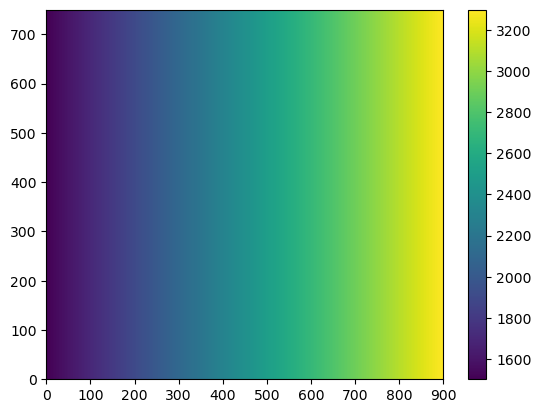

In [3]:
plt.pcolormesh(x_rho)
plt.colorbar()

In [4]:
#load GEBCO 2023 geometry

gebco_2023_bed = os.path.join(data_dir,'raw','GEBCO_2023','GEBCO_2023_sub_ice_topo.nc')

g23 = xr.load_dataset(gebco_2023_bed)

g23 = g23.sel(lon=slice(30,110),lat=slice(-85,-55))
g23

long,latg = np.meshgrid(g23.lon,g23.lat)
g23 = g23.assign_coords({"longitude": (("lat", "lon"), long), "latitude": (("lat", "lon"), latg)})

In [5]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(1e6,3.3e6)).sel(y=slice(1.5e6,0)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive


In [6]:
whichBathy='bedmachine' #options: 'bedmachine' or 'gebco'
if whichBathy =='gebco':
    # make new dataset with all variables on same grid
    geom = bm3.draft.to_dataset(name='draft')

    # interp GEBCO2023 bathy to this grid.
    g23_bathy_i = -griddata((g23['longitude'].values.flatten(),g23['latitude'].values.flatten()),g23['elevation'].values.flatten(),(geom.lon.values,geom.lat.values),'nearest').astype(np.float32)
    geom['bathy']=(['y','x'],g23_bathy_i)


    # make masks
    geom['mask_full']=bm3.mask
    geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
    geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))
elif whichBathy =='bedmachine':
    
    geom = bm3
    # make masks
    geom['mask_full']=bm3.mask
    geom["mask_ice"]=np.isfinite(geom.mask_full.where(geom.mask_full==3,np.NaN))
    geom["mask_ocean"]=np.isfinite(geom.mask_full.where((geom.mask_full==0)|(geom.mask_full==3),np.NaN))
    


In [7]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom['bathy']).plot.contourf(x='lon',y='lat',cmap='cmo.deep',levels=np.array([*np.arange(00,3250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

In [8]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom.draft).plot.contourf(x='lon',y='lat',cmap='cmo.ice',levels=np.array([*np.arange(-2250,50,50)]),add_colorbar=False,extend='min')
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

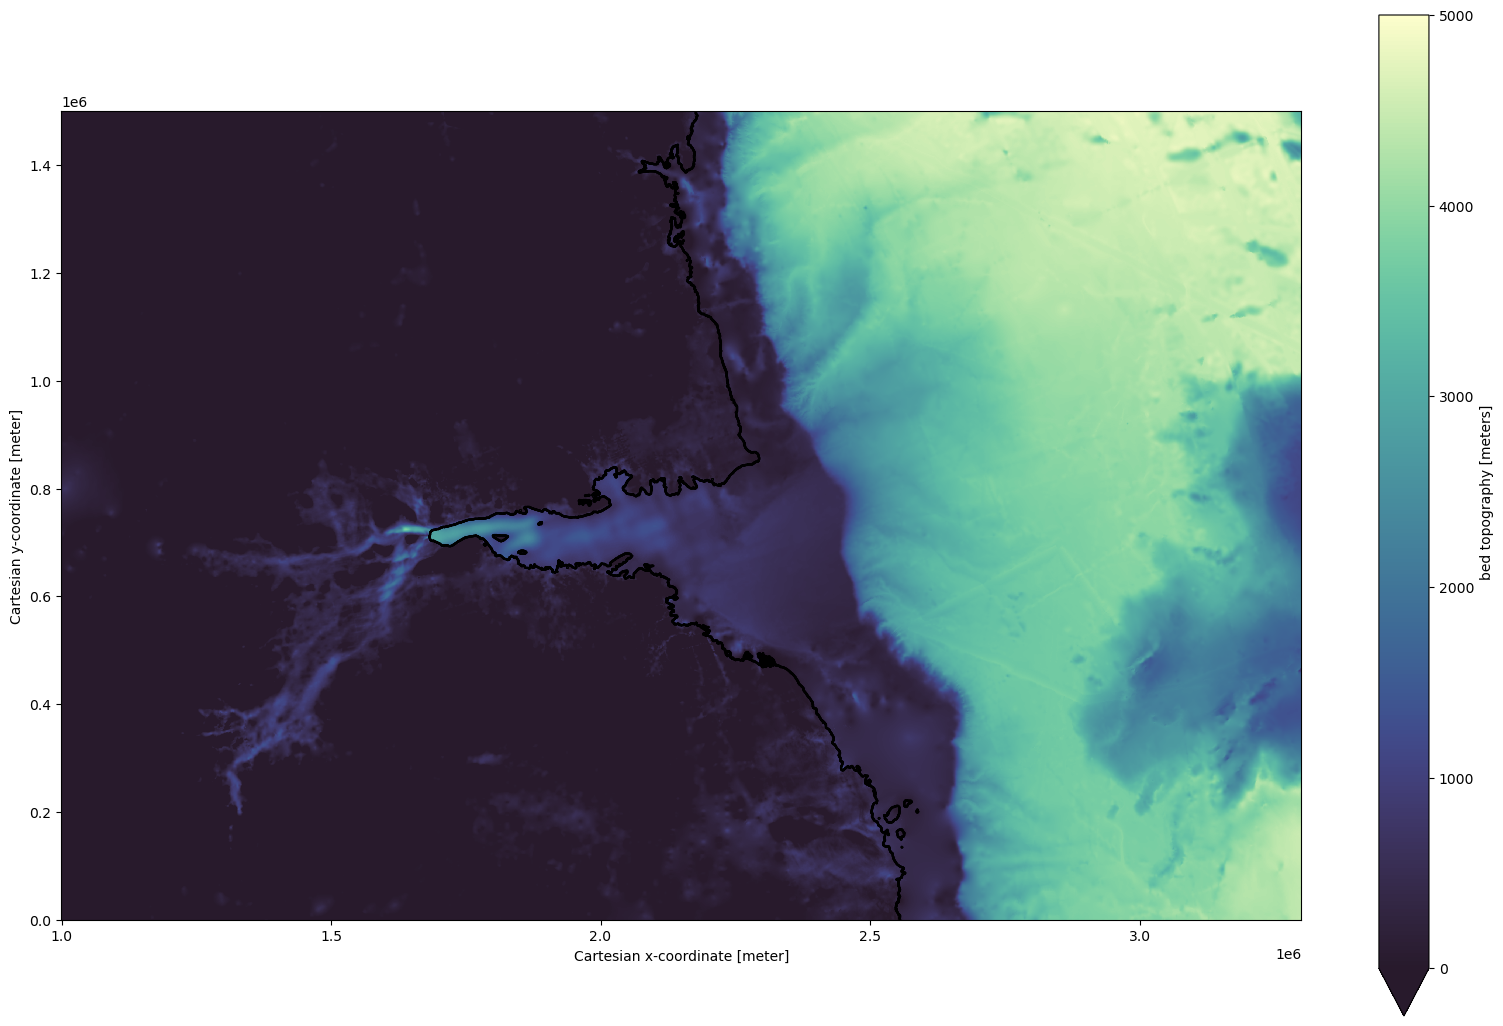

In [9]:
# plot of chosen subset
fig,ax=plt.subplots(figsize=(20,13))
geom.bathy.plot(vmin=000,vmax=5000,cmap='cmo.deep_r')
geom.mask_ocean.plot.contour(colors='k')
ax.set_aspect('equal','box')

plt.show()
fig,ax=plt.subplots(figsize=(20,13))
geom.draft.plot(vmin=-2500,vmax=0,cmap='cmo.ice')
geom.mask_ice.plot.contour(colors='k')
ax.set_aspect('equal','box')

In [10]:
#load south polar stereographic projection to convert from grid point distance in m to lat/lon and back

#get lat/lon coordinates at all grid points by shifting the grid to the lower left corner of the map
lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)

#calculate curvilinear coordinate distances at rho points
dx = haversine(lon[1::2,0:-2:2],lat[1::2,0:-2:2],lon[1::2,2::2],lat[1::2,2::2])
dy = haversine(lon[0:-2:2,1::2],lat[0:-2:2,1::2],lon[2::2,1::2],lat[2::2,1::2])


#calculate curvilinear coordinate metrices
pm = 1.0/dx
pn = 1.0/dy
 
dndx = np.empty_like(pm)
dmde = np.empty_like(pn)

dndx[:,1:-1] = 0.5*(pn[:,2:] - pn[:,:-2])
dmde[1:-1,:] = 0.5*(pm[2:,:] - pm[:-2,:])

dndx[:,0]  = 2*dndx[:,1]  - dndx[:,2]
dndx[:,-1] = 2*dndx[:,-2] - dndx[:,-3]
dmde[0,:]  = 2*dmde[1,:]  - dmde[2,:]
dmde[-1,:] = 2*dmde[-2,:] - dmde[-3,:]

#subset lat and lon at rho, psi, u and v points
lon_rho = lon[1::2,1::2]
lat_rho = lat[1::2,1::2]

lon_psi = lon[2:-1:2,2:-1:2]
lat_psi = lat[2:-1:2,2:-1:2]

lon_u = lon[1::2,2:-1:2]
lat_u = lat[1::2,2:-1:2]

lon_v = lon[2:-1:2,1::2]
lat_v = lat[2:-1:2,1::2]

In [11]:
lat_s = geom.lat.values.flatten()
lon_s = geom.lon.values.flatten()

In [12]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

def grid_data(data):
    return griddata((lon_s,lat_s),data,(lon_rho,lat_rho),'nearest')

roms_tmp = {}
for key in ['bathy','draft','mask_ice','mask_ocean']:
    roms_tmp[key] = grid_data(geom[key].values.flatten())
    print('interpolated',key)

interpolated bathy
interpolated draft
interpolated mask_ice
interpolated mask_ocean


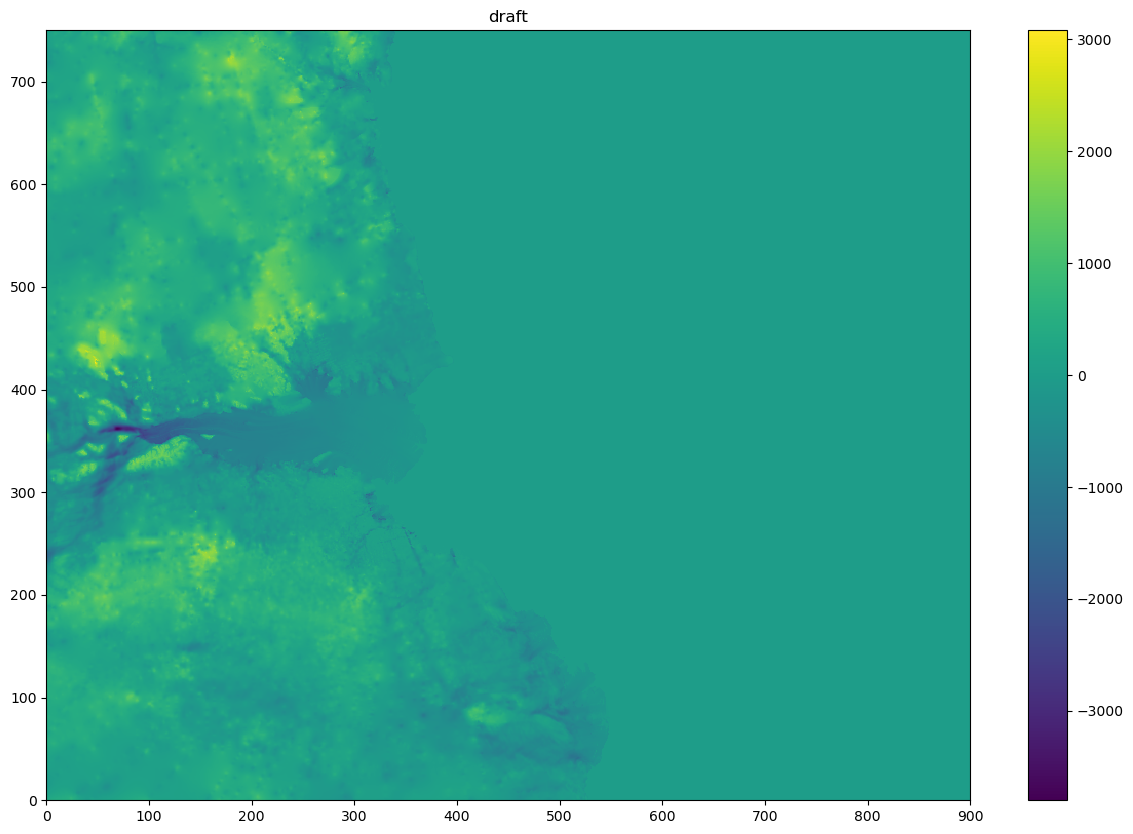

In [13]:
plt.close()
for key,data in roms_tmp.items():
    fig,ax = plt.subplots(figsize=(15,10))
    if key=='draft':
        plot = ax.pcolormesh(data)        
    else:
        plot = ax.pcolormesh(data)
    ax.set_title(key)
    plt.colorbar(plot,ax=ax)
    ax.set_aspect('equal')
    plt.show()

In [14]:
try: 
    from functions import GridStiffness
except:
    print('couldn''t load')


couldnt load


/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:75: RuntimeWarning: divide by zero encountered in divide
  hx = abs(h[:,1:] - h[:,:-1]) / (h[:,1:] + h[:,:-1])
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:76: RuntimeWarning: divide by zero encountered in divide
  hy = abs(h[1:,:] - h[:-1,:]) / (h[1:,:] + h[:-1,:])
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:78: RuntimeWarning: invalid value encountered in multiply
  hx = hx * umask
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:79: RuntimeWarning: invalid value encountered in multiply
  hy = hy * vmask


  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


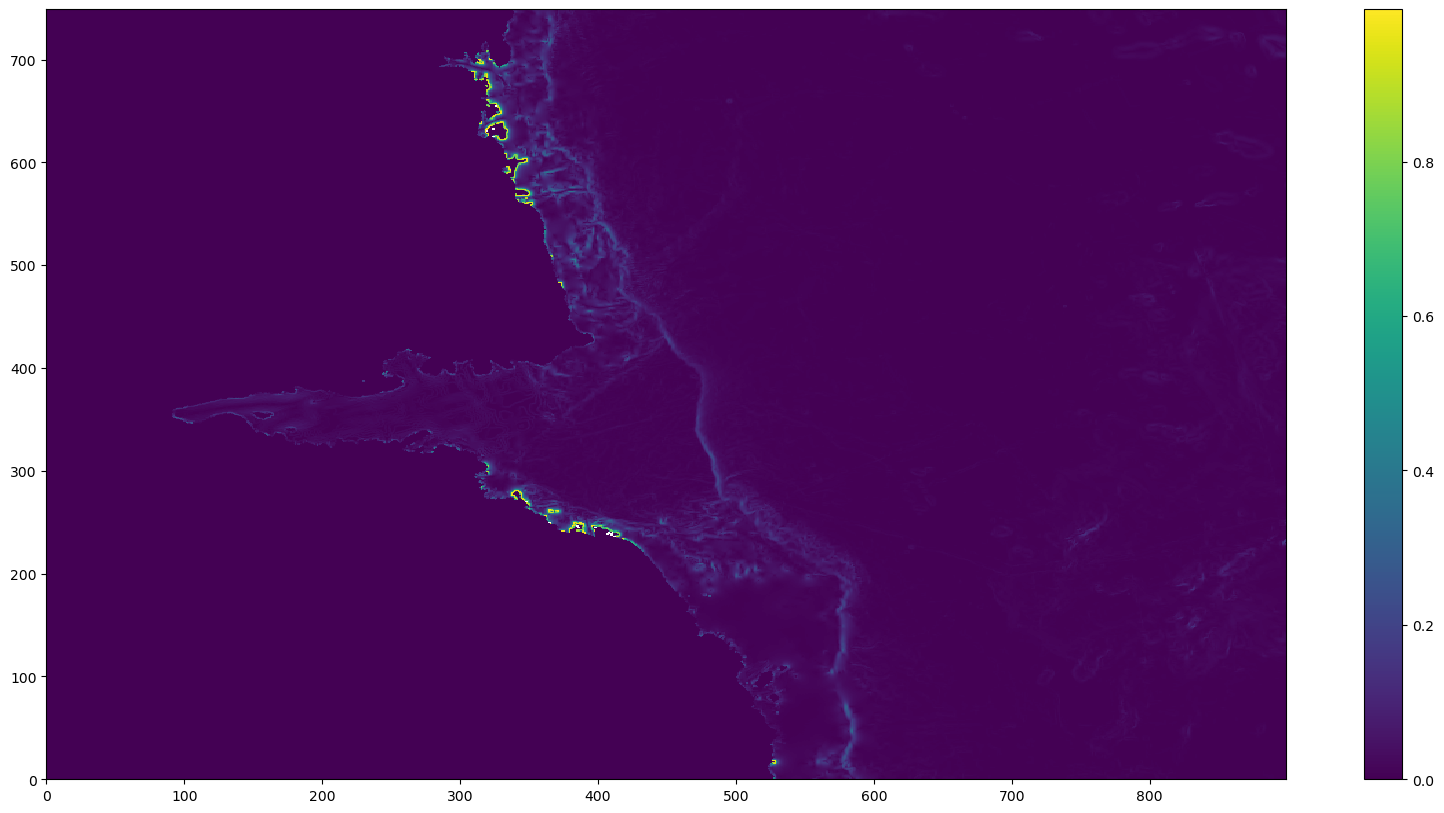

/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:136: RuntimeWarning: divide by zero encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:136: RuntimeWarning: invalid value encountered in divide
  zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:138: RuntimeWarning: divide by zero encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:138: RuntimeWarning: invalid value encountered in divide
  zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
/home/woden/Documents/amery-hires-setup/src/functions/GridStiffness.py:140: RuntimeWarning: invalid value encountered in multiply
  zx[k,:] = zx[k,:] * umask
/home/wo

  
Minimum r-value =  nan
Maximum r-value =  nan
Mean    r-value =  nan
Median  r-value =  nan


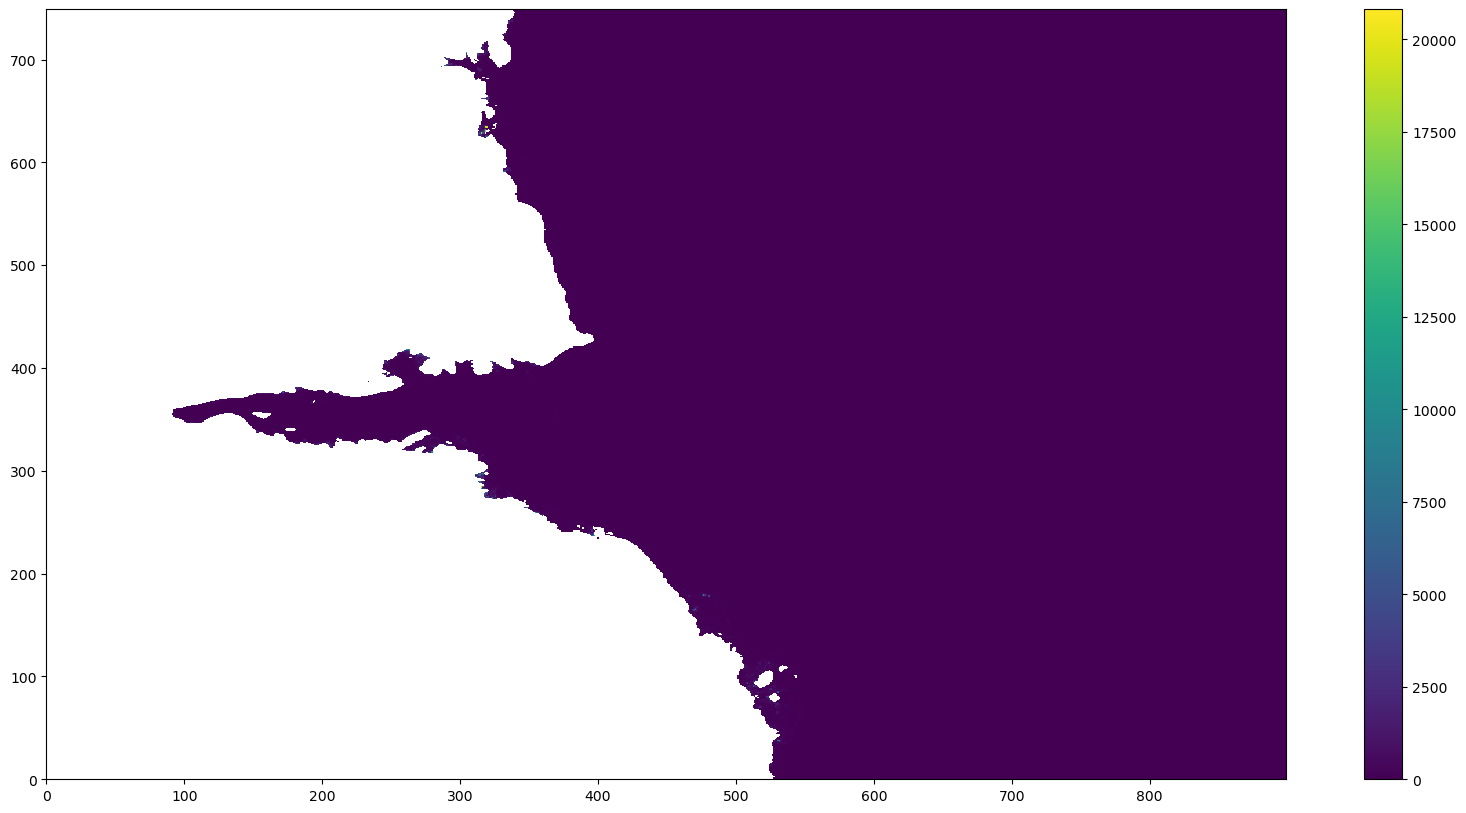

In [15]:
# from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness


N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=50
hc=Tcline # if Vtransform==2, hc=Tcline

z_rho_pre,z_w_pre,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bathy'],roms_tmp['draft'])


fig = plt.figure(figsize=(20,10))
grd_rx0_pre=GridStiffness.rx0(roms_tmp['bathy'],roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx0_pre)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_pre=GridStiffness.rx1(z_w_pre,roms_tmp['mask_ocean'])
plt.pcolormesh(grd_rx1_pre)
plt.colorbar()
plt.show()

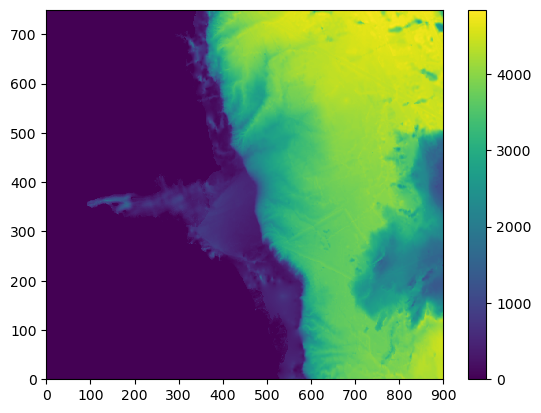

In [16]:
plt.pcolormesh(roms_tmp['bathy']+roms_tmp['draft'])
plt.colorbar()

In [17]:
# do checks
print('min/max zice is',roms_tmp['draft'].min(),'/',roms_tmp['draft'].max())
print('min/max h is',roms_tmp['bathy'].min(),'/',roms_tmp['bathy'].max())
print('min/max wct is',(roms_tmp['draft']+roms_tmp['bathy']).min(),'/',(roms_tmp['draft']+roms_tmp['bathy']).max())

min/max zice is -3799.7085 / 3080.7537
min/max h is -3080.7537 / 4838.785
min/max wct is 0.0 / 4838.785


In [18]:
# First round of smoothing

bed = roms_tmp['bathy']
bed_raw = roms_tmp['bathy']

ice = roms_tmp['draft']

mask = roms_tmp['mask_ocean']
maskNaN = mask.copy() # make a nan mask.
maskNaN = np.where(maskNaN==0,np.NaN,maskNaN)

# first, make any bedrock above MSL, and any ice above MSL to 0. (remove mountains)
min_depth0=0.1
ice[ice>0] = 0
bed[bed < min_depth0] = min_depth0 #note that bathy cannot >=0

# for any locations where there is wct<min_depth0; deepen the ice a bit until it is at least min_depth0
wct = bed + ice
ice[wct<min_depth0] = -bed[wct<min_depth0] + min_depth0  
wct = bed + ice

# smooth the wct and bed, then deepen the ice to correct for smoothed wct/bed.
rx0in = 0.3
max_iter = 100

Area = 1/(pm*pn)

wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)

ice = wct - bed

Old Max Roughness value is:  0.9998082518577576


DeltaBathymetry =  -231247.0
New Max Roughness value is:  0.30000582337379456
Old Max Roughness value is:  0.9998950958251953


DeltaBathymetry =  -778529.0
New Max Roughness value is:  0.3000057339668274


In [19]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

whole domain
min/max zice is -3799.6084 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.099975586 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 0.5207797884941101 / 4838.78515625
min/max wct is 0.33106938004493713 / 4838.78515625


In [20]:
# where ever the wct<min_depth, deepen the 

bed_smooth1 = bed.copy()
ice_smooth1 = ice.copy()
wct_smooth1 = bed.copy()+ice.copy()
min_depth = 50.0
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth
wct=bed+ice

In [21]:
# do checks
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin((ice*maskNaN)),'/',np.nanmax((ice*maskNaN)))
print('min/max h is',np.nanmin((bed*maskNaN)),'/',np.nanmax((bed*maskNaN)))
print('min/max wct is',np.nanmin((wct*maskNaN)),'/',np.nanmax((wct*maskNaN)))

min/max zice is -3799.6084 / 0.0
min/max h is 0.1 / 4838.785
min/max wct is 0.099975586 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


  
Minimum r-value =  0.0
Maximum r-value =  0.33524036407470703
Mean    r-value =  0.00749179792698536
Median  r-value =  0.0009137133602052927


  
Minimum r-value =  0.0
Maximum r-value =  1437.6422133294718
Mean    r-value =  2.3416874776771133
Median  r-value =  0.24493435939305783


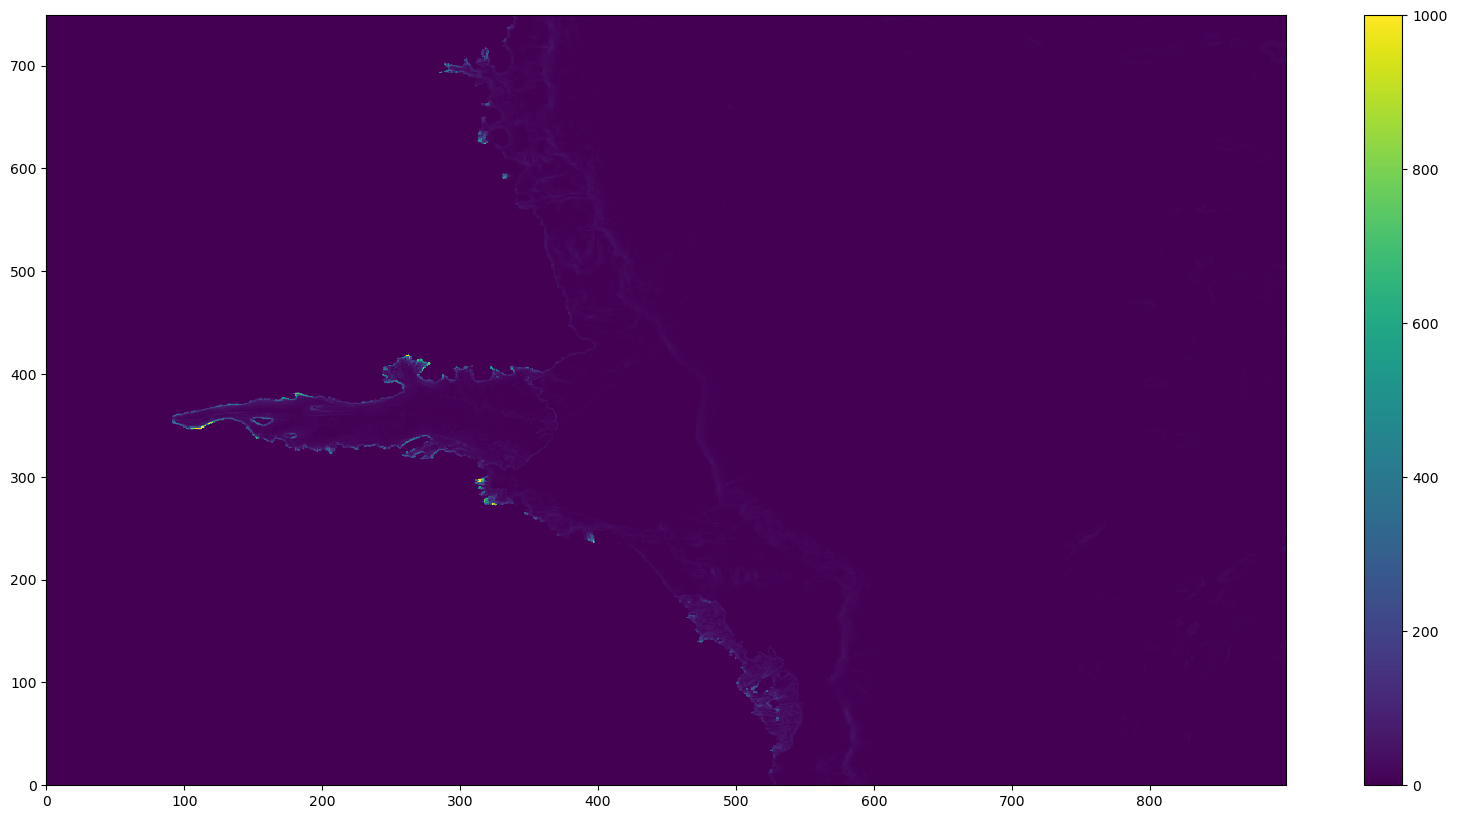

In [22]:

N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=250
hc=Tcline # if Vtransform==2, hc=Tcline

z_rho_mid,z_w_mid,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,bed,ice)

fig = plt.figure(figsize=(20,10))
grd_rx0_mid=GridStiffness.rx0(bed,mask)
plt.pcolormesh(grd_rx0_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_mid=GridStiffness.rx1(z_w_mid,mask)
plt.pcolormesh(grd_rx1_mid)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_mid,vmin=0,vmax=1000)
plt.colorbar()
plt.show()

In [23]:
# # crop mountain again and ensure thin layer between ice and bed
# mask = roms_tmp['mask_ocean']
# ice[ice > 0] = 0
# bed[mask==0] = -ice[mask==0] + min_depth0
# wct = bed + ice
# ii = (wct < min_depth0) & (mask == 1)
# bed[ii] = -ice[ii] + min_depth0
# wct = bed + ice

In [24]:
# # deepen bed under ice to min depth
# min_depth = 50.0
# ii = (bed + ice < min_depth) & (mask == 1)
# bed[ii] = -ice[ii] + min_depth

In [25]:
# Second round of smoothing 
bed, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),bed,rx0in,Area,max_iter)
wct, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct,rx0in,Area,max_iter)

ice = wct-bed

bed_smooth2 = bed.copy()
ice_smooth2 = ice.copy()

# now re-check that min_depth is obeyed for all ocean points
ii = ((bed + ice) < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

# do the same for all non-ocean points
ii = ((bed + ice) < min_depth) & (mask == 0)
ice[ii] = min_depth-bed[ii] # for those locations, the depth needs to be min_depth above the bathy

wct=bed+ice

Old Max Roughness value is:  0.979418158531189


DeltaBathymetry =  -101839.5
New Max Roughness value is:  0.3000045120716095
Old Max Roughness value is:  0.9919247031211853


DeltaBathymetry =  -43049.0
New Max Roughness value is:  0.30000442266464233


In [26]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(wct).min(),'/',(wct).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -3749.7085 / 49.9
min/max h is 0.1 / 4838.785
min/max wct is 49.99994 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


In [27]:


roms_tmp['bed'] = bed
roms_tmp['ice'] = ice
roms_tmp['mask'] = mask

bathy


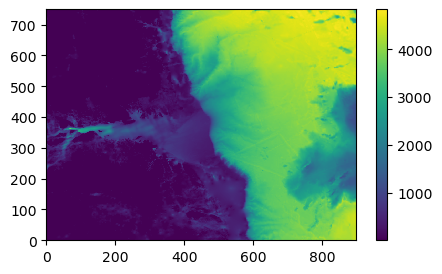

draft


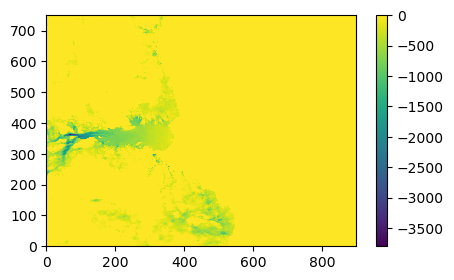

mask_ice


mask_ocean


bed


ice


mask


In [28]:
if plotting:
    plt.close()
    for k,v in roms_tmp.items():
        plt.figure(figsize=(5,3))
        print(k)
        plt.pcolormesh(v)
        plt.colorbar()
        plt.show()

In [29]:
# # plot of chosen subset
# fig,ax=plt.subplots(figsize=(15,10))
# plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bathy'],vmin=000,vmax=5000,cmap='cmo.deep_r')
# # geom.mask.plot.contour(colors='k')
# plt.colorbar()
# plt.show()
# fig,ax=plt.subplots(figsize=(15,10))
# plt.pcolormesh(lon_rho,lat_rho,bed,vmin=000,vmax=5000,cmap='cmo.deep_r')
# # geom.mask.plot.contour(colors='k')
# plt.colorbar()
# plt.show()
# fig,ax=plt.subplots(figsize=(15,10))
# plt.pcolormesh(lon_rho,lat_rho,roms_tmp['bed']*roms_tmp['mask']-roms_tmp['bathy']*roms_tmp['mask'],cmap='cmo.balance',vmin=-50,vmax=50)
# # geom.mask.plot.contour(colors='k')
# plt.colorbar()


In [30]:
mask = mask.astype(float)
mindxy = min(np.hstack((1/pm.flatten(),1/pn.flatten())))
maskNaN = mask.copy()
maskNaN[mask==0]=np.nan
CFL = mindxy/abs(np.sqrt(9.81*wct))*maskNaN

print('max fast DT in s following CFL: ', np.nanmin(CFL))
print('max slow DT in s following CFL: ', np.nanmin(mindxy/8*maskNaN)) # approx max 8m/s baroclinic wave speed
print('Set ROMS timestep settings of at least: \n','DT <',np.nanmin(mindxy/8*maskNaN),'s \n NDTFAST >',(np.nanmin(mindxy/8*maskNaN)/np.nanmin(CFL)).round())
timescale = 12*60*60 #s
print('approximate viscosity settings for smoothing timescale of ',timescale/(60*60),' hrs')
print('visc2 for 2dx noise ~ ',(2*mindxy/(2*np.pi))**2 / timescale)
print('approximate diff settings are an order of magnitude lower:')
print('tnu2 ~ ',((2*mindxy/(2*np.pi))**2 / timescale/10))

max fast DT in s following CFL:  8.67147445678711
max slow DT in s following CFL:  236.15961967599594
Set ROMS timestep settings of at least: 
 DT < 236.15961967599594 s 
 NDTFAST > 27.0
approximate viscosity settings for smoothing timescale of  12.0  hrs
visc2 for 2dx noise ~  8.37158638959344
approximate diff settings are an order of magnitude lower:
tnu2 ~  0.8371586389593441


In [31]:
# do checks
print('whole domain')
print('min/max zice is',ice.min(),'/',ice.max())
print('min/max h is',bed.min(),'/',bed.max())
print('min/max wct is',(bed+ice).min(),'/',(bed+ice).max())
print('ocean cells')
print('min/max zice is',np.nanmin(ice*maskNaN),'/',np.nanmax(ice*maskNaN))
print('min/max h is',np.nanmin(bed*maskNaN),'/',np.nanmax(bed*maskNaN))
print('min/max wct is',np.nanmin(wct*maskNaN),'/',np.nanmax(wct*maskNaN))

whole domain
min/max zice is -3749.7085 / 49.9
min/max h is 0.1 / 4838.785
min/max wct is 49.99994 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


  
Minimum r-value =  0.0
Maximum r-value =  0.34410360455513
Mean    r-value =  0.007505591123358341
Median  r-value =  0.000914283562451601


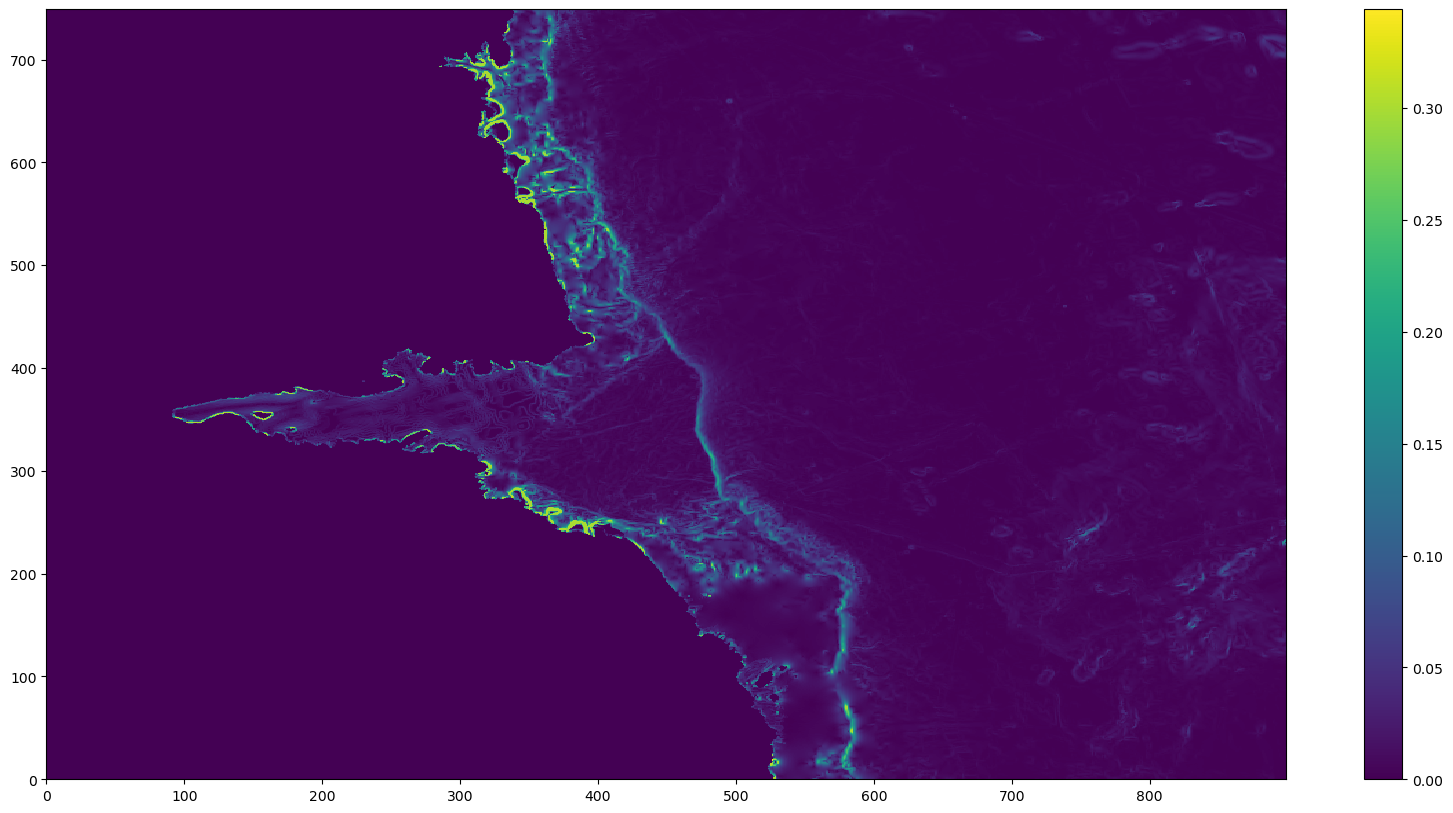

  
Minimum r-value =  0.0
Maximum r-value =  1437.6461493053887
Mean    r-value =  2.351474673464827
Median  r-value =  0.24512827731324616


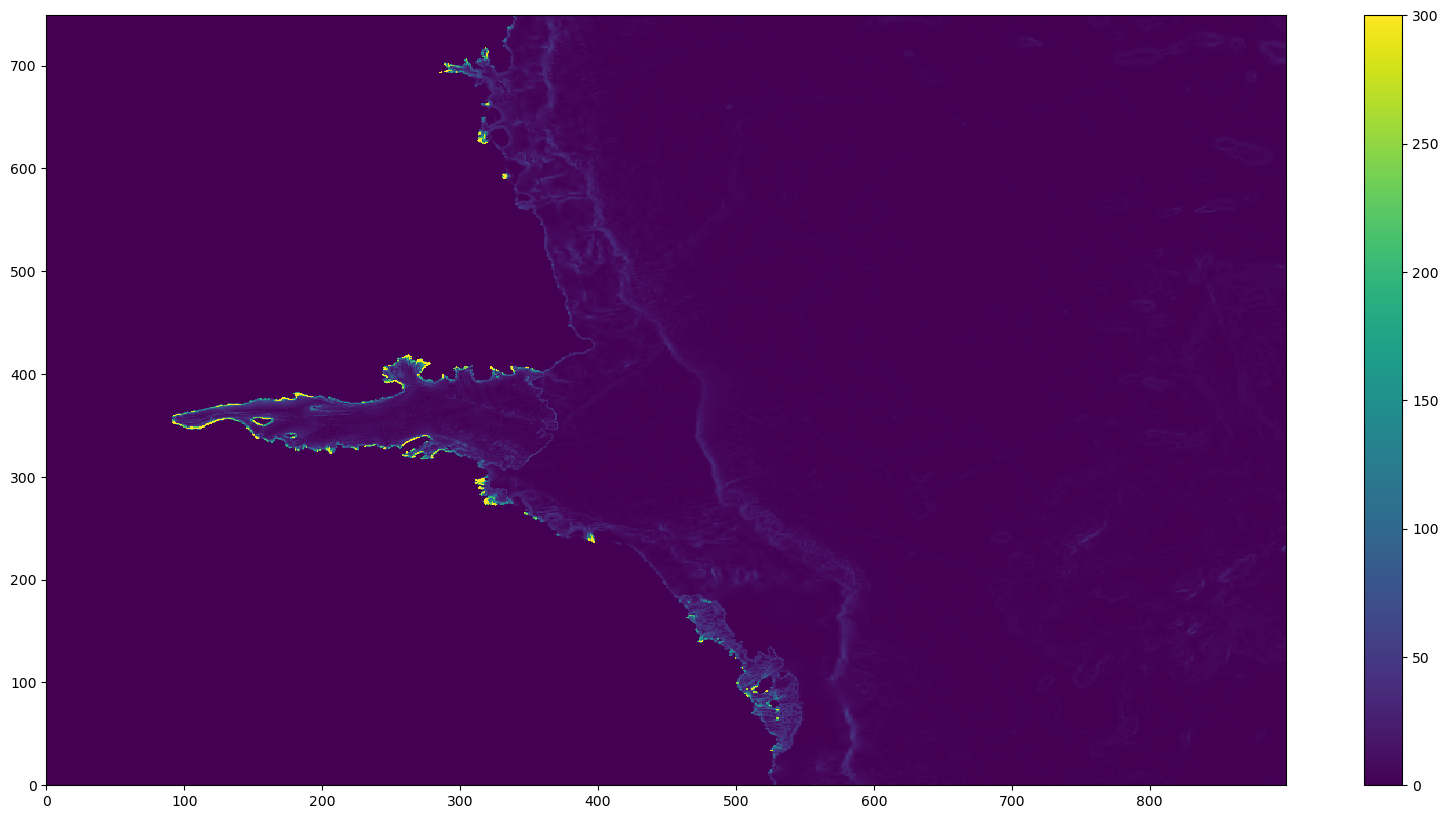

In [32]:
from ext.tools.calc_z import calc_z as calc_z_old
from functions import GridStiffness


N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=250
hc=Tcline # if Vtransform==2, hc=Tcline

z_rho_post,z_w_post,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,roms_tmp['bed'],roms_tmp['ice'])

fig = plt.figure(figsize=(20,10))
grd_rx0_post=GridStiffness.rx0(roms_tmp['bed'],roms_tmp['mask'])
plt.pcolormesh(grd_rx0_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
grd_rx1_post=GridStiffness.rx1(z_w_post,roms_tmp['mask'])
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_post,vmin=0,vmax=300)
plt.colorbar()
plt.show()

In [33]:
def adjustWCT(h_new,zice_new,h_alter,zice_alter,eta,xi):
    """
    function adjustWCT(h,zice,h_alter,zice_alter,eta,xi
    
    usage:
    h_new, zice_new=adjustWCT(h,zice,h_alter,zice_alter,eta,xi)
    
    This function adjust h[eta,xi] + h_alter and zice[eta,xi]+zice_alter. The intended use would be to 
    thicken the water column at a set location. Given rx1 is a function of steepness, depth and wct,
    the intended use would be, for example:
    h_alter=200 #lower the bathymetry by 200 m
    zice_alter=-150 #lower (neg zice is lower) zice by only 150m
    So resultant water column here starts 200m lower and is 50m thicker than previously. 
    
    To pass a range, use the slice literal:
    eta=slice(100,132)

    """
    h_new[eta,xi] = h_new[eta,xi] + h_alter
    zice_new[eta,xi] = zice_new[eta,xi] + zice_alter
    return h_new, zice_new

def adjustMask(mask_new,mask_alter,eta,xi):
    """
    function adjustMask(mask_new,mask_alter,eta,xi)
    
    usage:
    mask_new=adjustMask(mask_new,mask_alter,eta,xi)
    
    This function adjusts mask at[eta,xi] to the new value mask_alter.
    e.g.
    mask[eta,xi] = mask_new,
    will change the value of a mask at [eta,xi] to the new value 
    mask_alter.

    """    
    mask_new[eta,xi]=mask_alter
    return mask_new

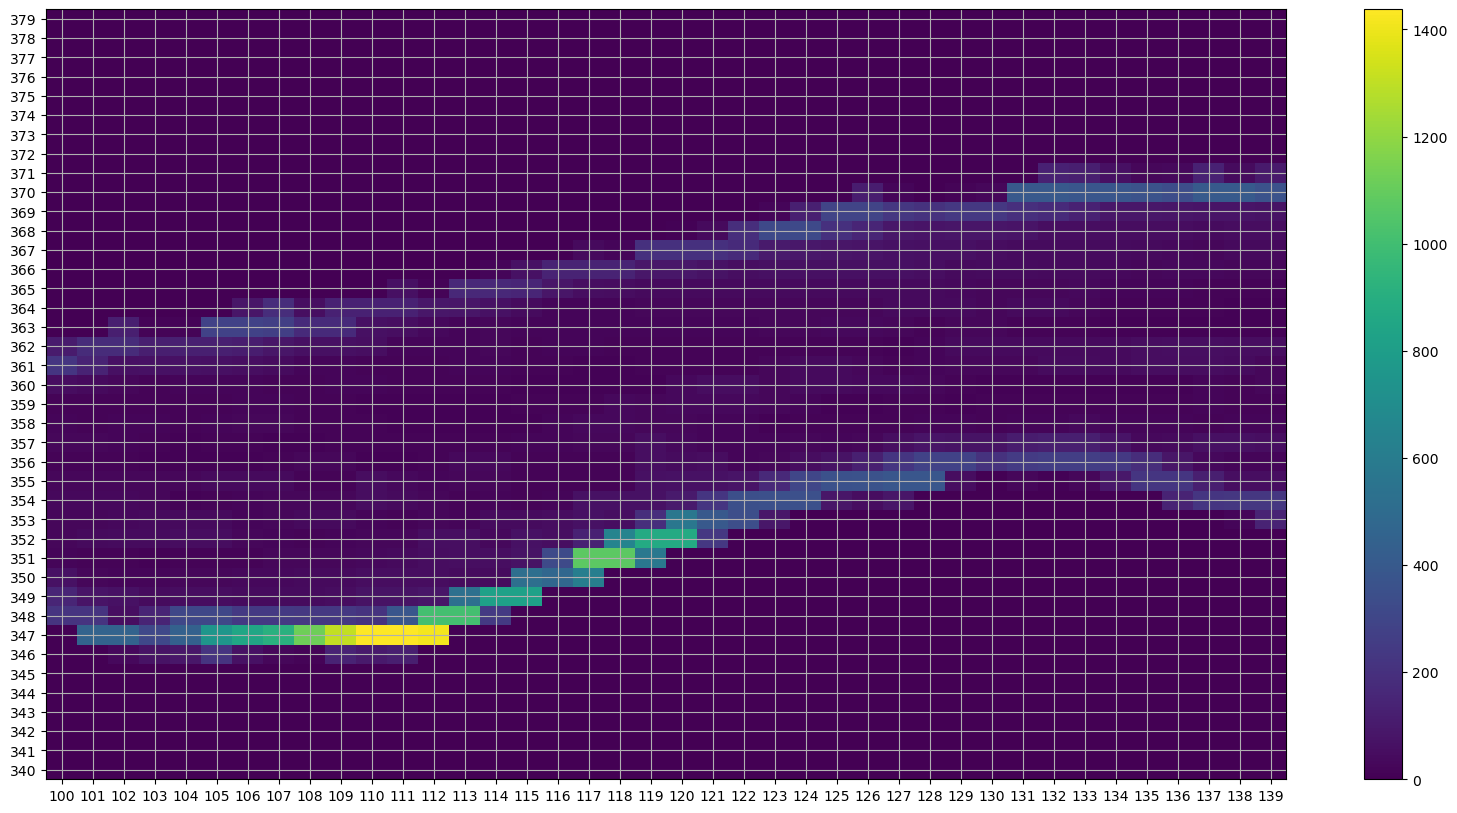

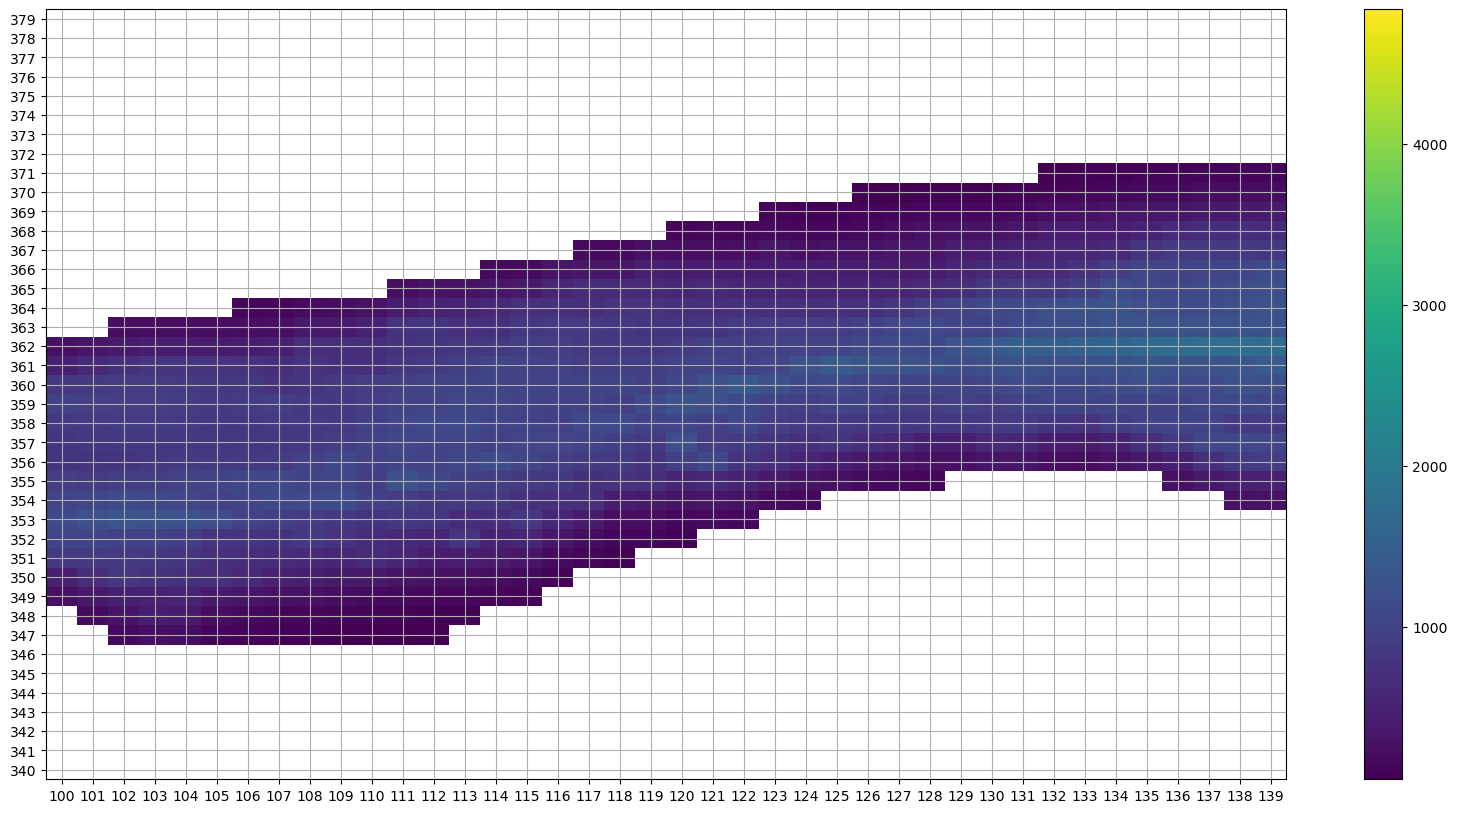

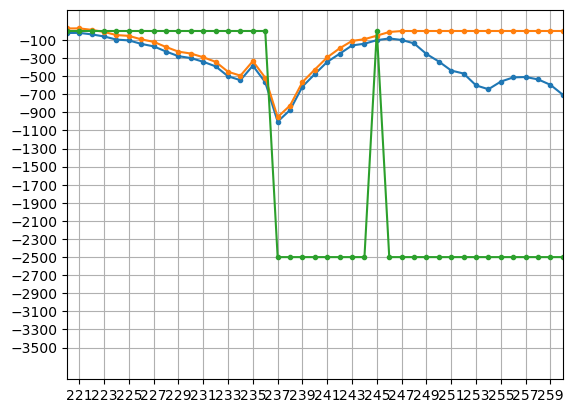

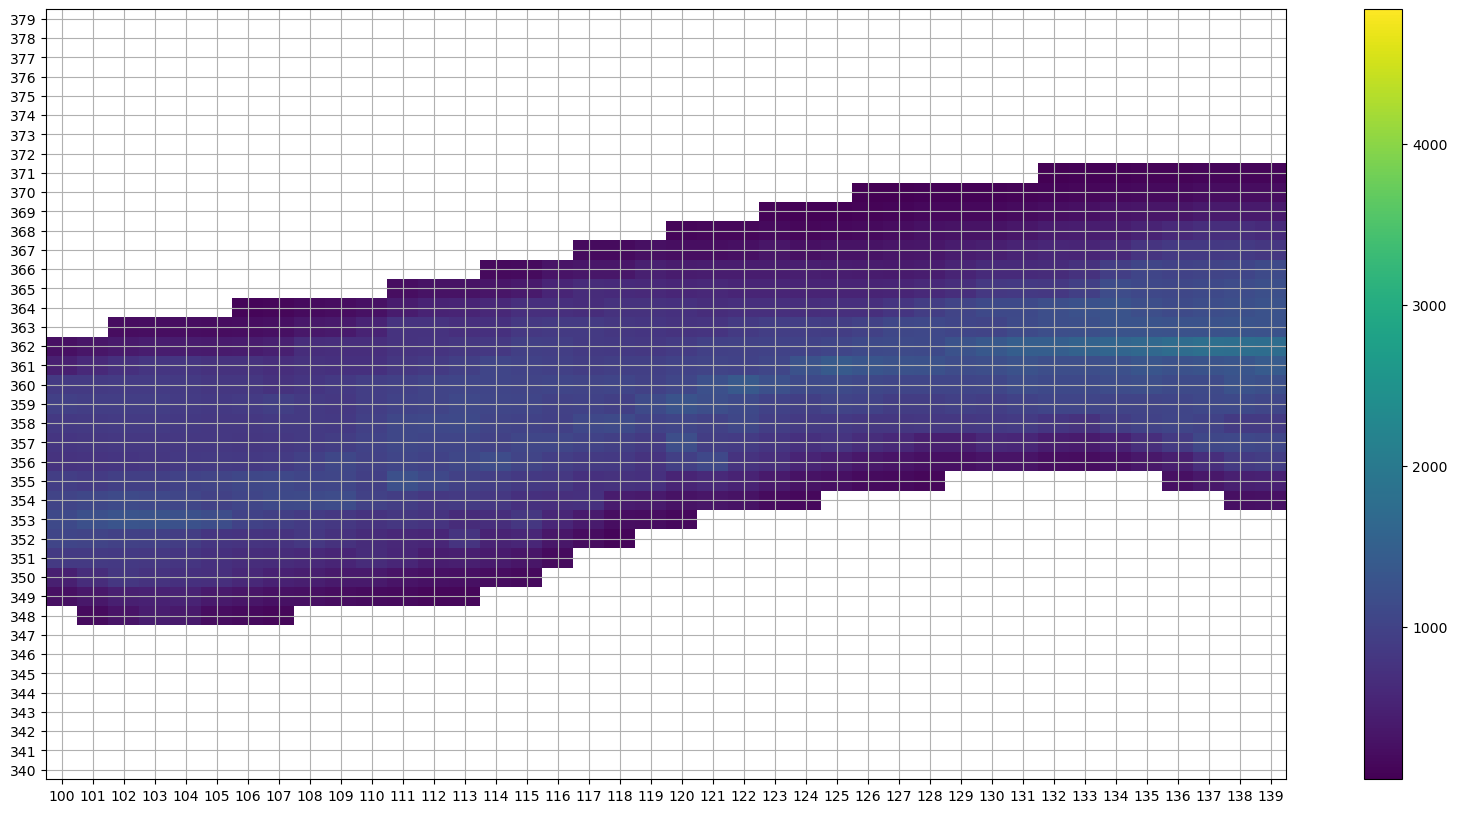

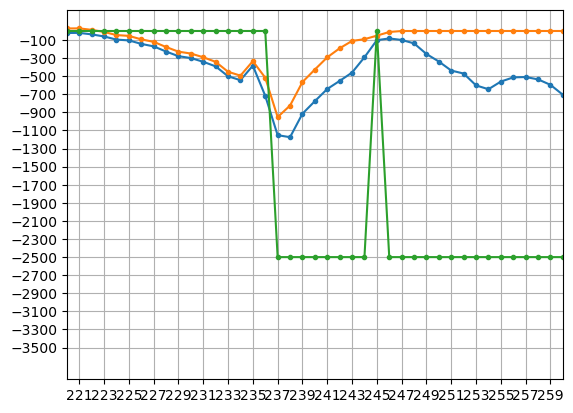

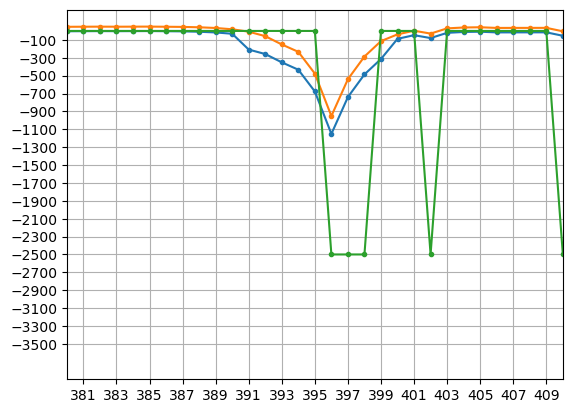

  
Minimum r-value =  0.0
Maximum r-value =  530.5313016784195
Mean    r-value =  2.1590382310742333
Median  r-value =  0.24431441588282934


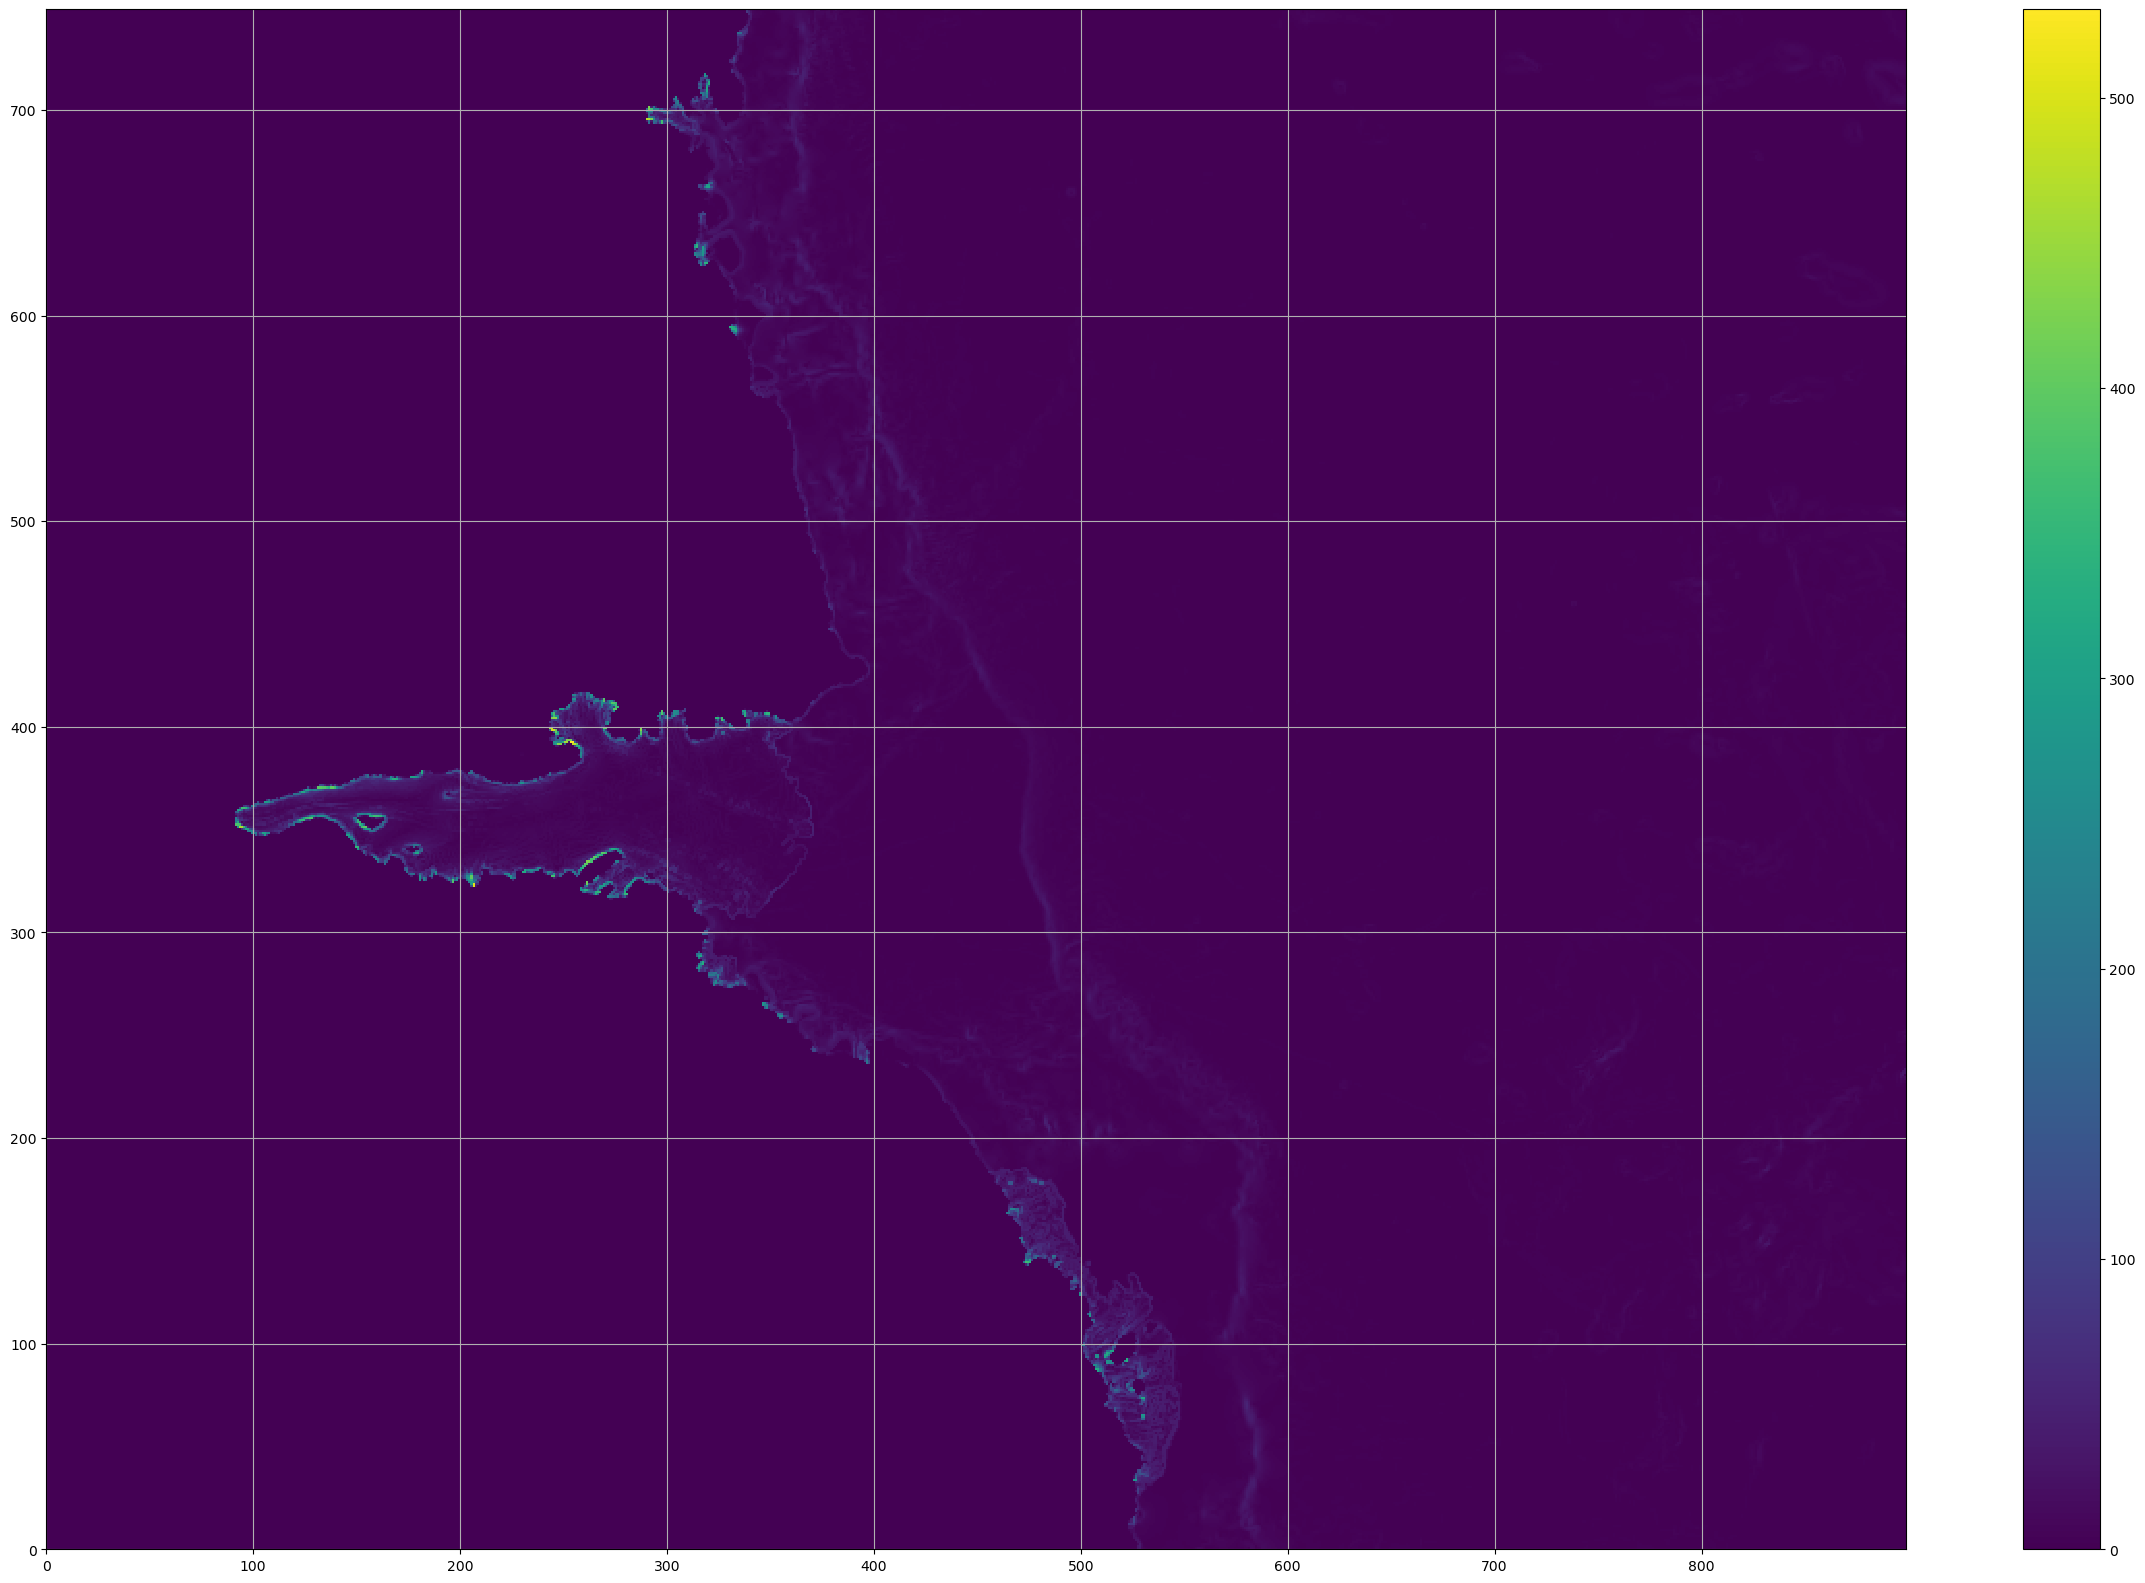

In [71]:
# !!! BEWARE, ALL YE WHO ENTER HERE, THE REALM OF HAND-EDITING SUB-ICE SHELF GEOMETRY. HERE BE DRAGONS. !!!

test=grd_rx1_post.copy()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh(grd_rx1_post)
plt.colorbar()
plt.grid()
plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
plt.xlim(100,140)
plt.ylim(340,380)
plt.show()

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((roms_tmp['bed']+roms_tmp['ice'])*maskNaN)
plt.grid()
plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
plt.colorbar()
plt.xlim(100,140)
plt.ylim(340,380)
plt.show()


plt.plot(-roms_tmp['bed'][:,396],'.-')
plt.plot(roms_tmp['ice'][:,396],'.-')
plt.plot(-1*roms_tmp['mask'][:,396]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.xlim(220,260)
plt.grid()
plt.show()


hhh=roms_tmp['bed'].copy()
zzz=roms_tmp['ice'].copy()
mmm=roms_tmp['mask'].copy()

# remove a long string of very thin very steep border cells (basically cells on the edge of a subglacial mountain side; see above plots of bedrock)
mmm=adjustMask(mmm,0,eta=347,xi=112)
mmm=adjustMask(mmm,0,eta=347,xi=111)
mmm=adjustMask(mmm,0,eta=347,xi=110)
mmm=adjustMask(mmm,0,eta=347,xi=109)
mmm=adjustMask(mmm,0,eta=347,xi=108)
mmm=adjustMask(mmm,0,eta=347,xi=107)
mmm=adjustMask(mmm,0,eta=347,xi=106)
mmm=adjustMask(mmm,0,eta=347,xi=105)
mmm=adjustMask(mmm,0,eta=347,xi=104)
mmm=adjustMask(mmm,0,eta=347,xi=103)
mmm=adjustMask(mmm,0,eta=347,xi=102)

# tweak water column bordering on edge of mountain range on eastern GL.
hhh,zzz=adjustWCT(hhh,zzz,h_alter=250,zice_alter=-150,eta=348,xi=112)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=+50,eta=349,xi=112)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=50,zice_alter=00,eta=350,xi=112)
mmm=adjustMask(mmm,0,eta=349,xi=slice(114,116))
mmm=adjustMask(mmm,0,eta=351,xi=slice(117,119))
mmm=adjustMask(mmm,0,eta=352,xi=slice(119,121))
mmm=adjustMask(mmm,0,eta=slice(347,349),xi=slice(112,116))
mmm=adjustMask(mmm,0,eta=slice(337,339),xi=slice(152,154))
mmm=adjustMask(mmm,0,eta=339,xi=152)
mmm=adjustMask(mmm,0,eta=348,xi=slice(108,113))
mmm=adjustMask(mmm,0,eta=348,xi=slice(108,113))
mmm=adjustMask(mmm,0,eta=350,xi=116)
mmm=adjustMask(mmm,0,eta=353,xi=slice(121,123))


# tweak water column bordering on barely grounded western mid shelf.
mmm=adjustMask(mmm,0,eta=slice(379,383),xi=slice(181,189))
mmm=adjustMask(mmm,0,eta=slice(381,383),xi=slice(179,181))
mmm=adjustMask(mmm,0,eta=slice(376,379),xi=slice(169,177))
mmm=adjustMask(mmm,0,eta=slice(378,381),xi=slice(187,194))

# tweak water column bordering on weird ear shaped area on western mid shelf.
mmm=adjustMask(mmm,0,eta=slice(417,421),xi=slice(259,266))
mmm=adjustMask(mmm,0,eta=415,xi=slice(271,274))
mmm=adjustMask(mmm,0,eta=414,xi=slice(269,273))
mmm=adjustMask(mmm,0,eta=slice(410,412),xi=slice(277,279))
mmm=adjustMask(mmm,0,eta=409,xi=277)
mmm=adjustMask(mmm,0,eta=slice(404,408),xi=slice(273,275))
mmm=adjustMask(mmm,0,eta=416,xi=264)
mmm=adjustMask(mmm,0,eta=413,xi=slice(271,275))

# tweak remove cells below tiny ice shelves just east of amery
mmm=adjustMask(mmm,0,eta=slice(287,300),xi=slice(309,315))
mmm=adjustMask(mmm,0,eta=slice(273,275),xi=slice(323,327))
mmm=adjustMask(mmm,0,eta=slice(273,279),xi=slice(316,318))
mmm=adjustMask(mmm,0,eta=slice(291,300),xi=slice(314,318))
mmm=adjustMask(mmm,0,eta=slice(272,280),xi=slice(316,320))
mmm=adjustMask(mmm,0,eta=slice(274,278),xi=slice(319,322))
mmm=adjustMask(mmm,0,eta=slice(278,279),xi=320)

# add sorsdal back in
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(243,247),xi=slice(391,394))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(236,244),xi=slice(391,397))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(242,245),xi=slice(394,397))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(238,242),xi=396)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(238,242),xi=397)
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=237,xi=slice(397,400))

# tweak remove cells below tiny ice shelves west of amery
mmm=adjustMask(mmm,0,eta=slice(591,593),xi=slice(331,333))
mmm=adjustMask(mmm,0,eta=624,xi=slice(317,319))
mmm=adjustMask(mmm,0,eta=slice(623,629),xi=slice(312,316))
hhh,zzz=adjustWCT(hhh,zzz,h_alter=150,zice_alter=-0,eta=slice(628,630),xi=slice(315,317))
mmm=adjustMask(mmm,0,eta=slice(691,706),xi=slice(286,291))
mmm=adjustMask(mmm,0,eta=702,xi=slice(291,293))
mmm=adjustMask(mmm,0,eta=slice(699,702),xi=slice(310,312))

# tweak cells in 're-entrant' branches of amery west side
mmm=adjustMask(mmm,0,eta=slice(406,412),xi=slice(320,328))
mmm=adjustMask(mmm,0,eta=slice(409,412),xi=slice(336,340))
mmm=adjustMask(mmm,0,eta=405,xi=323)
mmm=adjustMask(mmm,0,eta=slice(404,406),xi=slice(337,339))

roms_tmp['bed_altered']=hhh
roms_tmp['ice_altered']=zzz
roms_tmp['mask_altered']=mmm



mmmNaN = mmm.copy().astype('float')
mmmNaN[mmmNaN == 0] = np.NaN

fig = plt.figure(figsize=(20,10))
plt.pcolormesh((roms_tmp['bed']+roms_tmp['ice'])*mmmNaN)
plt.grid()
plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.plot(np.arange([340,370]),np.ones(np.arange([340,370]).shape)*112)
plt.colorbar()
plt.xlim(100,140)
plt.ylim(340,380)
plt.show()

plt.plot(-hhh[:,396],'.-')
plt.plot(zzz[:,396],'.-')
plt.plot(-1*mmm[:,396]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.xlim(220,260)
plt.grid()

plt.show()

plt.plot(-hhh[237,:],'.-')
plt.plot(zzz[237,:],'.-')
plt.plot(-1*mmm[237,:]*2500,'.-')
plt.xticks(np.arange(1,1000,2),np.arange(1,1000,2))
plt.yticks(np.arange(-3500,0,200))
plt.xlim(380,410)
plt.grid()

plt.show()



z_rho_test,z_w_test,=GridStiffness.calc_z(Vtransform,Vstretching,theta_s,theta_b,Tcline,hc,N,hhh,zzz)
grd_rx1_test=GridStiffness.rx1(z_w_test,mmm)

fig = plt.figure(figsize=(30,20))
plt.pcolormesh(grd_rx1_test)
plt.grid()
# plt.yticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xticks(np.arange(1.5,1000,1),np.arange(1,1000,1))
# plt.xlim(100,140)
# plt.ylim(340,380)
plt.colorbar()
plt.show()

In [72]:
handAdjustments=True
if handAdjustments:
    roms_tmp['bed_backup'] = roms_tmp['bed'].copy()
    roms_tmp['ice_backup'] = roms_tmp['ice'].copy()
    roms_tmp['mask_backup'] = roms_tmp['mask'].copy()
    roms_tmp['bed']=hhh.copy()
    roms_tmp['ice']=zzz.copy()
    roms_tmp['mask']=mmm.copy()
    
    bed = roms_tmp['bed'].copy()
    ice = roms_tmp['ice'].copy()
    mask = roms_tmp['mask'].copy()


In [75]:
# do checks

maskNaN = roms_tmp['mask'].copy().astype('float')
maskNaN[maskNaN == 0] = np.NaN

print('whole domain')
print('min/max zice is',roms_tmp['ice'].min(),'/',roms_tmp['ice'].max())
print('min/max h is',roms_tmp['bed'].min(),'/',roms_tmp['bed'].max())
print('min/max wct is',(roms_tmp['bed']+roms_tmp['ice']).min(),'/',(roms_tmp['bed']+roms_tmp['ice']).max())
print('ocean cells')
print('min/max zice is',np.nanmin(roms_tmp['ice']*maskNaN),'/',np.nanmax(roms_tmp['ice']*maskNaN))
print('min/max h is',np.nanmin(roms_tmp['bed']*maskNaN),'/',np.nanmax(roms_tmp['bed']*maskNaN))
print('min/max wct is',np.nanmin((roms_tmp['bed']+roms_tmp['ice'])*maskNaN),'/',np.nanmax((roms_tmp['bed']+roms_tmp['ice'])*maskNaN))

whole domain
min/max zice is -3749.7085 / 49.9
min/max h is 0.1 / 4838.785
min/max wct is 49.99994 / 4838.785
ocean cells
min/max zice is -2561.080078125 / 0.0
min/max h is 50.0 / 4838.78515625
min/max wct is 49.99993896484375 / 4838.78515625


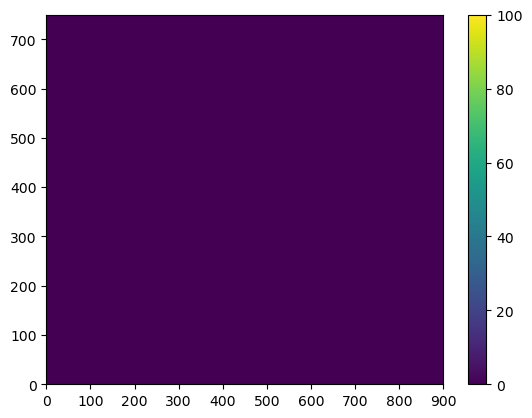

In [98]:
plt.pcolormesh(roms_tmp['ice'],vmin=0,vmax=100)
plt.colorbar()
plt.show()


# test this out
new_ice = roms_tmp['ice'].copy()

new_ice[(roms_tmp['ice']>0)]=0

roms_tmp['ice']=new_ice

plt.pcolormesh(roms_tmp['ice'],vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [101]:
ice=roms_tmp['ice']

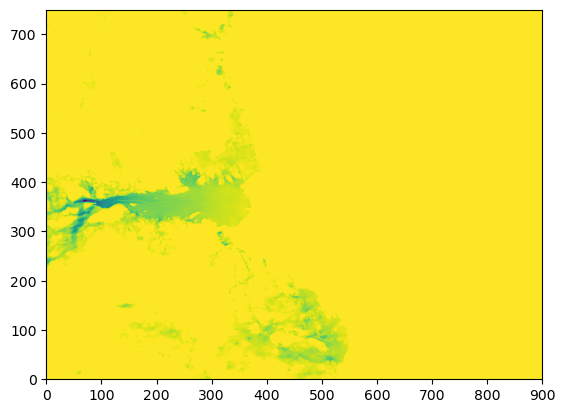

In [103]:
plt.pcolormesh(ice)

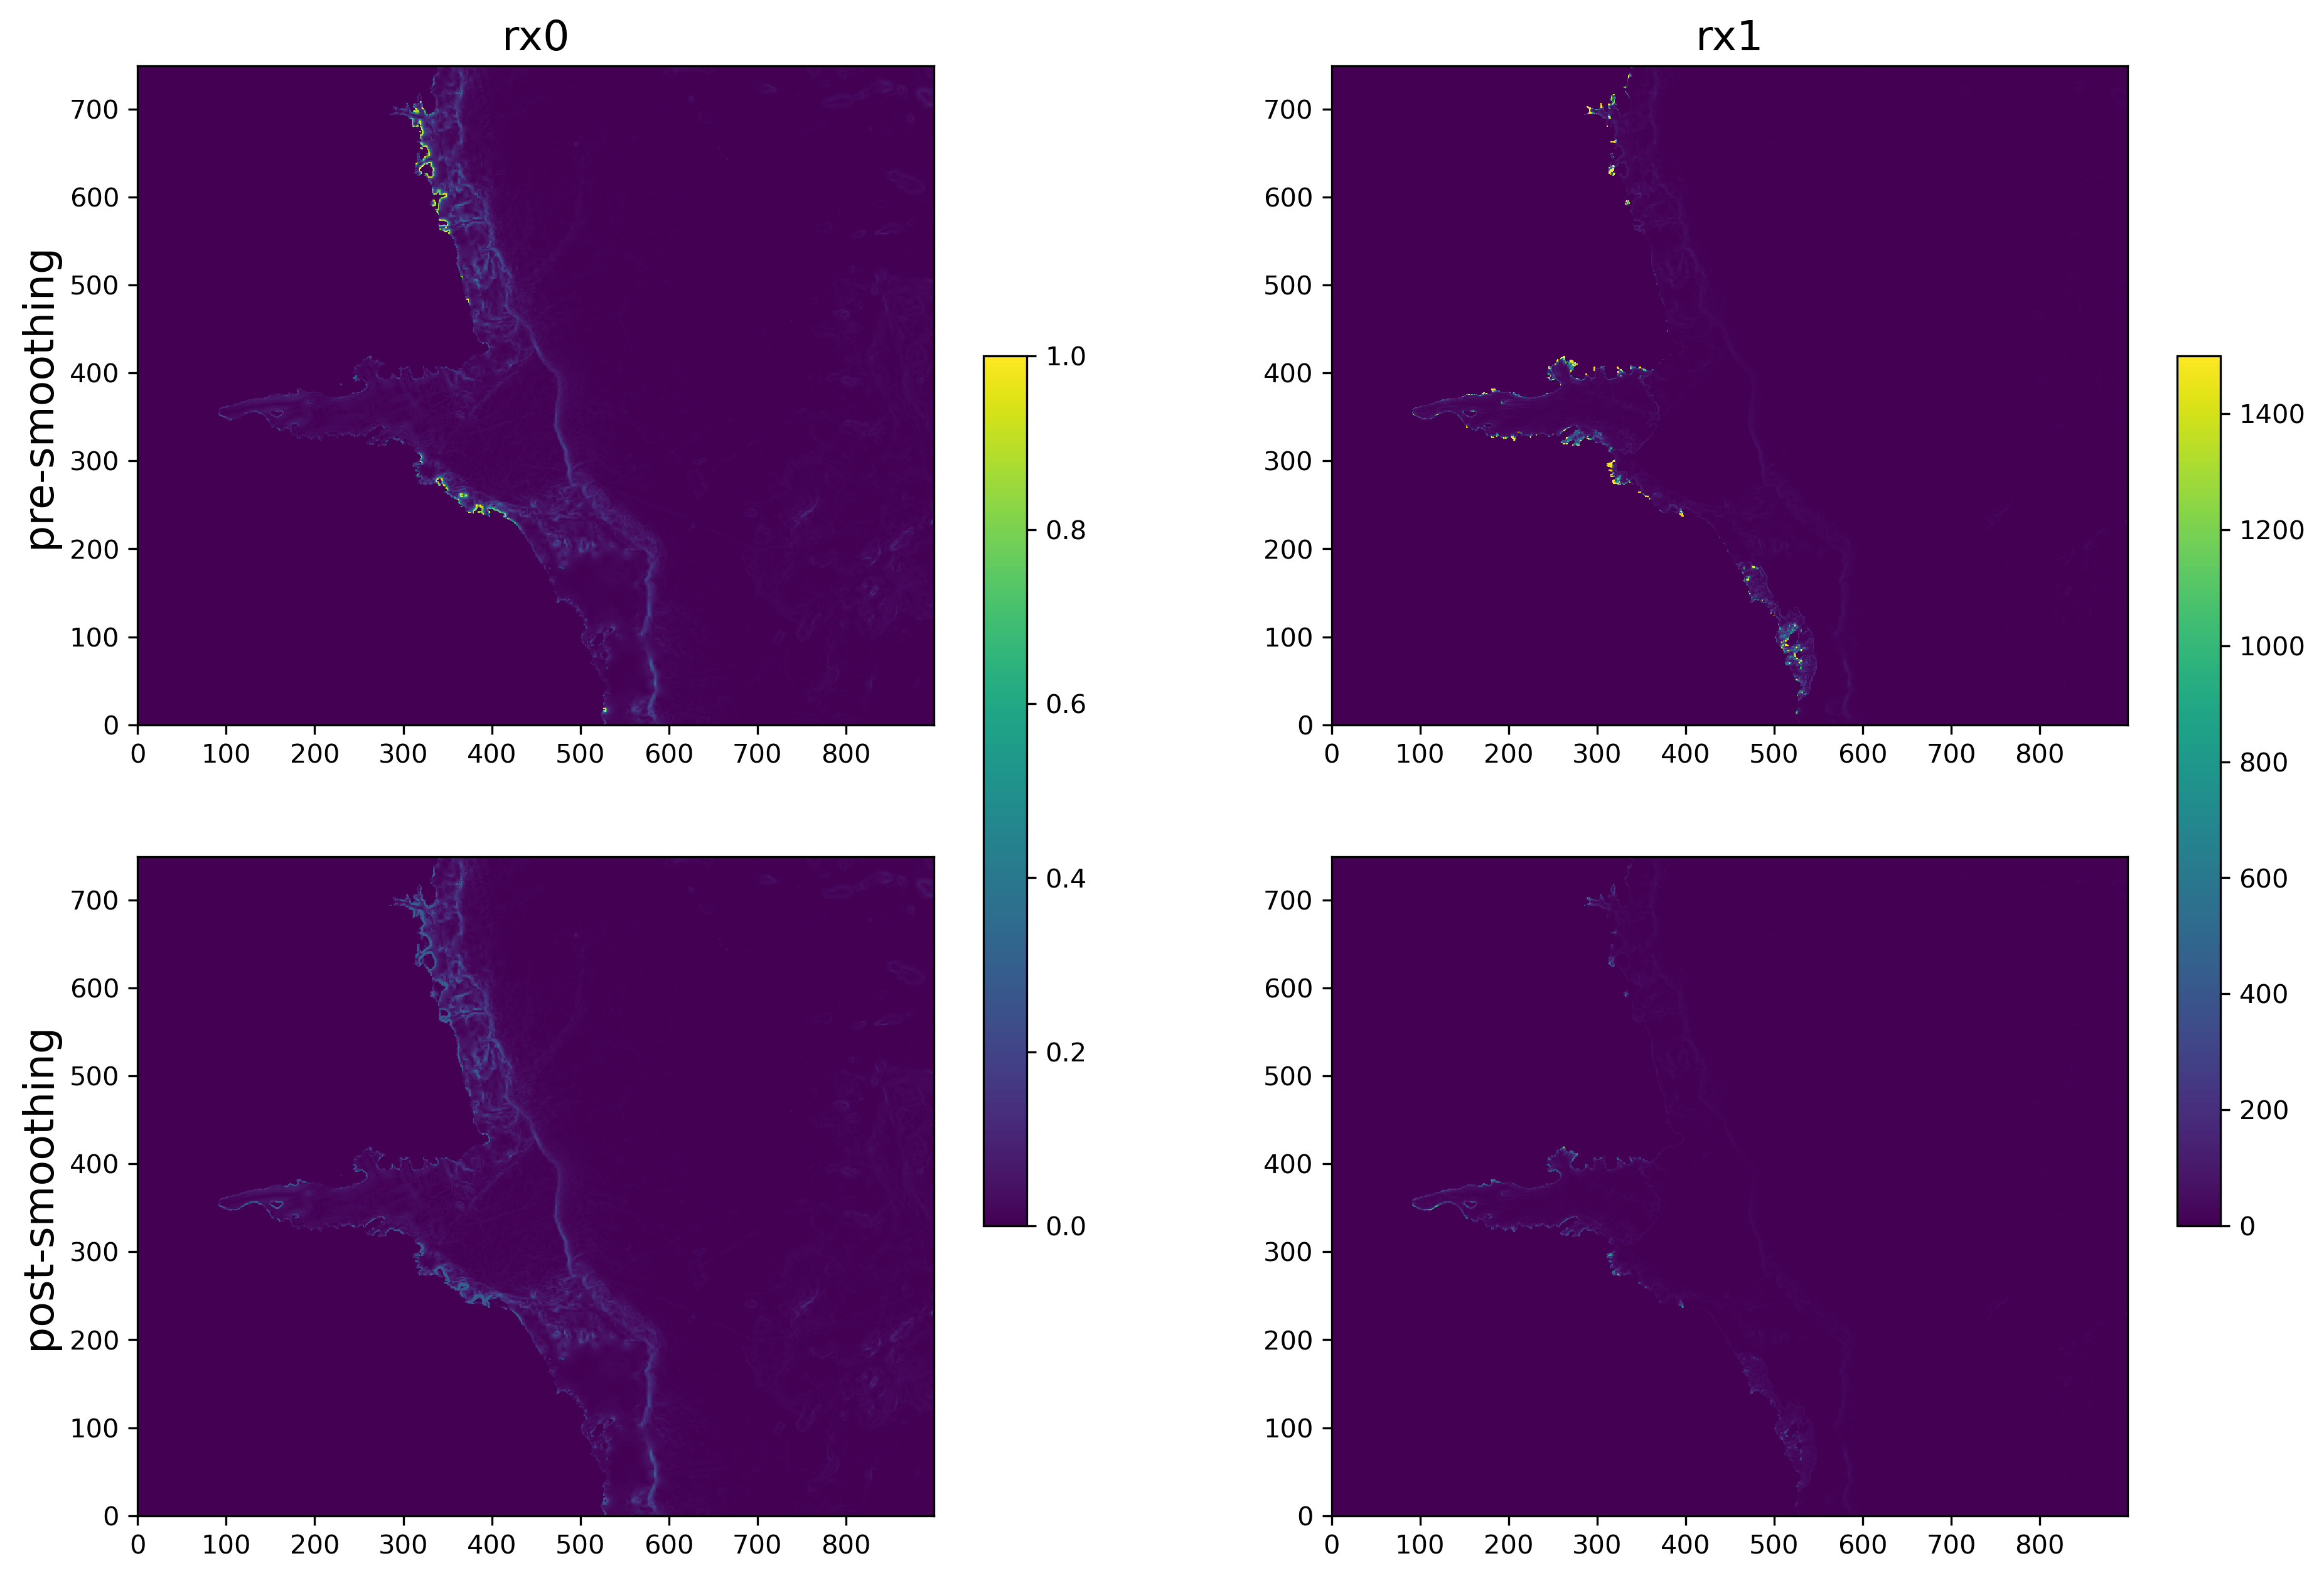

In [68]:

fig,axs = plt.subplots(2,2,figsize=[15,10],dpi=300)

ax = axs[0,0]
ax.pcolormesh(grd_rx0_pre,vmax=1)
ax.set_title('rx0',fontsize=16)
ax.set_ylabel('pre-smoothing',fontsize=16)
ax = axs[0,1]
grd_rx1_pre[np.isnan(grd_rx1_pre)]=0
ax.pcolormesh(grd_rx1_pre,vmax=1500)
ax.set_title('rx1',fontsize=16)
ax = axs[1,0]
im=ax.pcolormesh(grd_rx0_post,vmax=1)
plt.colorbar(im,ax=axs[:,0],shrink=0.6)
ax.set_ylabel('post-smoothing',fontsize=16)
ax = axs[1,1]
im=ax.pcolormesh(grd_rx1_post,vmax=1500)
plt.colorbar(im,ax=axs[:,1],shrink=0.6)

plt.savefig('../out/pre_post_rxVals.png')

In [104]:
#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


mask_u,mask_v,mask_psi = uvp_masks(mask)

mask_rho_da = xr.DataArray(mask,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})

In [105]:
print('saving to',out_path)
grd.to_netcdf(out_path,unlimited_dims='bath')

saving to /home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd.nc


In [38]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
#hand editing SIGH

mask2 = mask
mask2[310:390,80:220]=0

#set spherical flag to 1, since we're creating a curvilinear spherical grid
spherical_da = xr.DataArray(int(1),name='spherical',attrs={'flag_meanings': 'Cartesian spherical',
 'flag_values': np.array([0, 1], dtype=int),
 'long_name': 'grid type logical switch'})

xl = mr*np.size(lat_rho,1)*1000
xl_da = xr.DataArray(xl,name='xl',attrs={'long_name': 'basin length in the XI-direction', 'units': 'meter'} )
el = mr*np.size(lon_rho,0)*1000
el_da = xr.DataArray(el,name='el',attrs={'long_name': 'basin length in the ETA-direction', 'units': 'meter'} )

angle = lon_rho/180.0*np.pi
angle_da = xr.DataArray(angle,name='angle',dims=['eta_rho','xi_rho'],attrs={'long_name': 'angle between XI-axis and EAST', 'units': 'radians'})

pn_da = xr.DataArray(pn,name="pn",dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in ETA', 'units': 'meter-1'})
pm_da = xr.DataArray(pm,name='pm',dims=['eta_rho','xi_rho'],attrs={'long_name': 'curvilinear coordinate metric in XI', 'units': 'meter-1'})

dmde_da = xr.DataArray(dmde,name='dmde',dims=['eta_rho','xi_rho'],attrs={'long_name': 'ETA-derivative of inverse metric factor pm', 'units': 'meter'})
dndx_da = xr.DataArray(dndx,name='dndx',dims=['eta_rho','xi_rho'],attrs={'long_name': 'XI-derivative of inverse metric factor nm', 'units': 'meter'})

f = 2*7.29e-5*np.sin(lat_rho*np.pi/180)
f_da = xr.DataArray(f,name='f',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Coriolis parameter at RHO-points', 'units': 'second-1'})

h_da = xr.DataArray(bed,name='h',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model bathymetry at RHO-points', 'units': 'meter'})
# hraw_da = xr.DataArray(bed_raw.astype(float),name='hraw',dims=['eta_rho','xi_rho'],attrs={'long_name': 'Working unmasked bathymetry at RHO-points', 'units': 'meter'})

zice_da = xr.DataArray(ice,name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'model ice draft at RHO-points', 'units': 'meter'})
# zice_raw_da = xr.DataArray(ice_raw.astype(float),name='zice',dims=['eta_rho','xi_rho'],attrs={'long_name': 'raw unmasked model ice draft at RHO-points', 'units': 'meter'})

lon_rho_da = xr.DataArray(lon_rho,name='lon_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'longitude of RHO-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_rho_da = xr.DataArray(lat_rho,name='lat_rho',dims=['eta_rho','xi_rho'],attrs={'long_name': 'latitude of RHO-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_psi_da = xr.DataArray(lon_psi,name='lon_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'longitude of psi-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_psi_da = xr.DataArray(lat_psi,name='lat_psi',dims=['eta_psi','xi_psi'],attrs={'long_name': 'latitude of psi-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_u_da = xr.DataArray(lon_u,name='lon_u',dims=['eta_u','xi_u'],attrs={'long_name': 'longitude of u-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_u_da = xr.DataArray(lat_u,name='lat_u',dims=['eta_u','xi_u'],attrs={'long_name': 'latitude of u-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})
lon_v_da = xr.DataArray(lon_v,name='lon_v',dims=['eta_v','xi_v'],attrs={'long_name': 'longitude of v-points',
 'standard_name': 'longitude',
 'units': 'degree_east'})
lat_v_da = xr.DataArray(lat_v,name='lat_v',dims=['eta_v','xi_v'],attrs={'long_name': 'latitude of v-points',
 'standard_name': 'latitude',
 'units': 'degree_north'})


mask_u,mask_v,mask_psi = uvp_masks(mask2)

mask_rho_da = xr.DataArray(mask2,name='mask_rho',dims=['eta_rho','xi_rho'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on RHO-points'})
mask_psi_da = xr.DataArray(mask_psi,name='mask_psi',dims=['eta_psi','xi_psi'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on psi-points'})
mask_u_da = xr.DataArray(mask_u,name='mask_u',dims=['eta_u','xi_u'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on u-points'})
mask_v_da = xr.DataArray(mask_v,name='mask_v',dims=['eta_v','xi_v'],attrs={'flag_meanings': 'land water',
 'flag_values': np.array([ 0.,  1.]),
 'long_name': 'mask on v-points'})

grd2 = xr.Dataset({'spherical':spherical_da,
                'xl':xl_da,
                'el':el_da,
                'angle':angle_da,
                'pm':pn_da,
                'pn':pn_da,
                'dndx':dndx_da,
                'dmde':dmde_da,
                'f':f_da,
                'h':h_da,
              #   'hraw':hraw_da,
                'zice':zice_da,
              #   'zice_raw':zice_raw_da,
                'lon_rho':lon_rho_da,
                'lat_rho':lat_rho_da,
                'lon_psi':lon_psi_da,
                'lat_psi':lat_psi_da,
                'lon_u':lon_u_da,
                'lat_u':lat_u_da,
                'lon_v':lon_v_da,
                'lat_v':lat_v_da,
                'mask_rho':mask_rho_da,
                'mask_psi':mask_psi_da,
                'mask_u':mask_u_da,
                'mask_v':mask_v_da,},
               attrs={'history': 'GRID file using make_grid.py,'+str(datetime.date.today()),
                      'type': 'ROMS grid file'})




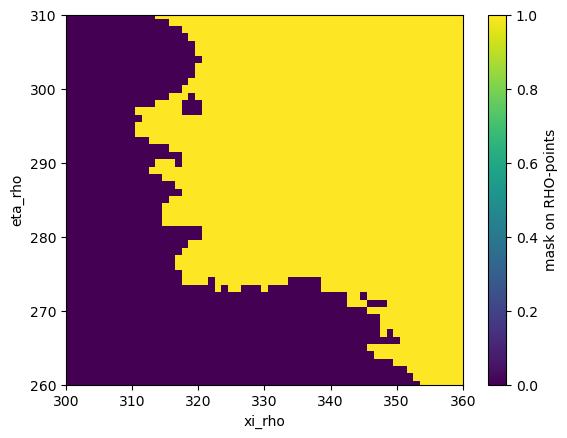

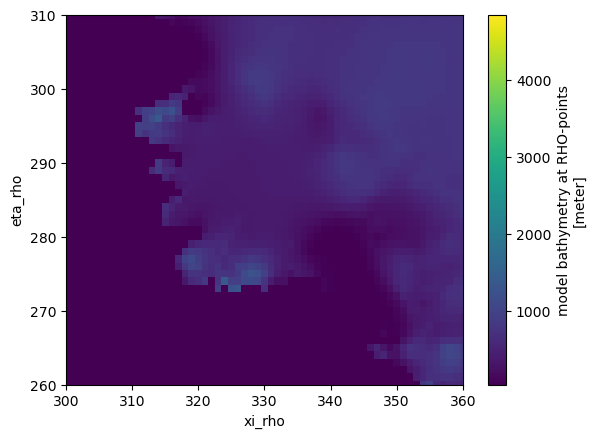

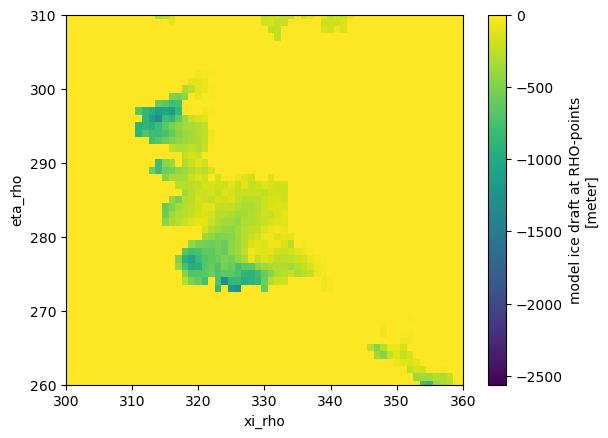

(260.0, 310.0)

In [ ]:
grd2.mask_rho.plot()
plt.xlim(300,360)
plt.ylim(260,310)
plt.show()
grd2.h.plot()
plt.xlim(300,360)
plt.ylim(260,310)
plt.show()
grd2.zice.plot()
plt.xlim(300,360)
plt.ylim(260,310)
plt.show()
(grd2.h+grd2.zice).plot()
plt.xlim(300,360)
plt.ylim(260,310)

In [ ]:
grd2.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v2.nc',unlimited_dims='bath')

grd2.mask_u.plot()

In [ ]:
(grd.zice+grd.h).min()

<xarray.DataArray ()>
array(50.)

In [ ]:
STOP

NameError: name 'STOP' is not defined

In [ ]:

test = xr.open_dataset(out_path)

grd2 = test
test

<xarray.Dataset>
Dimensions:    (eta_rho: 750, xi_rho: 900, eta_psi: 749, xi_psi: 899,
                eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/25)
    spherical  int64 ...
    xl         int64 ...
    el         int64 ...
    angle      (eta_rho, xi_rho) float64 ...
    pm         (eta_rho, xi_rho) float64 ...
    pn         (eta_rho, xi_rho) float64 ...
    ...         ...
    lon_v      (eta_v, xi_v) float64 ...
    lat_v      (eta_v, xi_v) float64 ...
    mask_rho   (eta_rho, xi_rho) float64 ...
    mask_psi   (eta_psi, xi_psi) float64 ...
    mask_u     (eta_u, xi_u) float64 ...
    mask_v     (eta_v, xi_v) float64 ...
Attributes:
    history:  GRID file using make_grid.py,2023-05-09
    type:     ROMS grid file

In [ ]:
# remove isolated cells (lakes and single cell islands)

from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr


islands = compare_neighbors(test.mask_rho)

new_mask = grd2.mask_rho.where(~islands,np.logical_not(grd2.mask_rho))



test['mask_rho'] = new_mask

In [ ]:
# #hand editing SIGH
# test['mask_rho'][348,112]=0
# test['mask_rho'][352,112]=0
# test['mask_rho'][351,118]=0
# test['mask_rho'][349,115]=0
# test['mask_rho'][353,112]=0
# test['mask_rho'][353,111]=0
# test['mask_rho'][347,112]=0
# test['mask_rho'][347,111]=0
# test['mask_rho'][352,111]=0



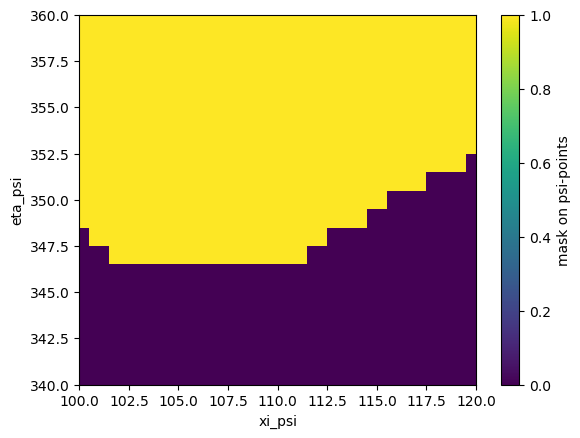

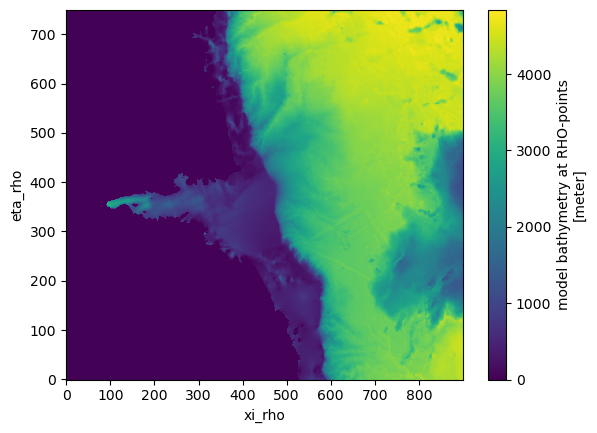

In [ ]:
test.mask_psi.plot()
plt.xlim(100,120)
plt.ylim(340,360)
plt.show()
test.h.where(test.mask_rho,min_depth).plot()
# plt.xlim(100,120)
# plt.ylim(340,360)

In [ ]:


min_depth=50.0

zice_corrected  = test.zice.where(test.mask_rho,0) # set values of zice outside of ocean to 0
zice_corrected = zice_corrected.where(zice_corrected<=0,0) # set zice values to be max of 0.

h_corrected = test.h.where(np.isfinite(test.h),0) # set bathy nan values to 0
h_corrected  = h_corrected.where(test.mask_rho,min_depth) # set bathy outside of mask to min_depth
h_corrected  = h_corrected.where(h_corrected>=min_depth,min_depth) # set bathy below min_depth to min_depth

h_corrected = h_corrected.where(~(h_corrected+zice_corrected<min_depth),-zice_corrected+min_depth) # make bathy deeper where wct < min_depth

grd2['h'] = h_corrected
grd2['zice'] = zice_corrected

grd2.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v3.nc',unlimited_dims='bath')


In [ ]:
# some more post smoothing
rx0in = 0.3
max_iter = 150

grd3 = xr.open_dataset('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v2.nc')
# smooth bathy again, since you just introduced steps and ensure min depth after
Area = 1/(grd3.pm*grd3.pn)

wct = grd3.h+grd3.zice
bed = grd3.h

wct_new, HmodifVal, ValueFct = smoothing_PlusMinus_rx0(np.ones_like(wct),wct.values,rx0in,Area,max_iter)

# ice = grd3.zice.values
# bed = -ice + wct_new

# ii = (bed + ice < min_depth) & (mask == 1)
# bed[ii] = -ice[ii] + min_depth

# bed = bed*mask #final is masked

# # set to min_depth
# bed[bed<min_depth] = min_depth

Old Max Roughness value is:  0.774588483650786


DeltaBathymetry =  <xarray.DataArray ()>
array(1.5)
New Max Roughness value is:  0.30000000876720057


IndexError: 2-dimensional boolean indexing is not supported. 

In [ ]:

ice = grd3.zice.values
bed = -ice + wct_new

ii = (bed + ice < min_depth) & (mask == 1)
bed[ii] = -ice[ii] + min_depth

bed = bed*mask #final is masked

# set to min_depth
h_new = bed*grd3.mask_rho # convert to xarray da
h_new  = h_new.where(grd3.mask_rho,min_depth) # set bathy outside of mask to min_depth
h_new  = h_new.where(h_new>=min_depth,min_depth) # set bathy less than min_depth to nan


In [ ]:

def inpaint_nans(im):
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = scipy.signal.convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = scipy.signal.convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im

In [ ]:

grd3['h'] = h_new
grd3.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v4.nc',unlimited_dims='bath')

<xarray.DataArray ()>
array(-895.11755371)

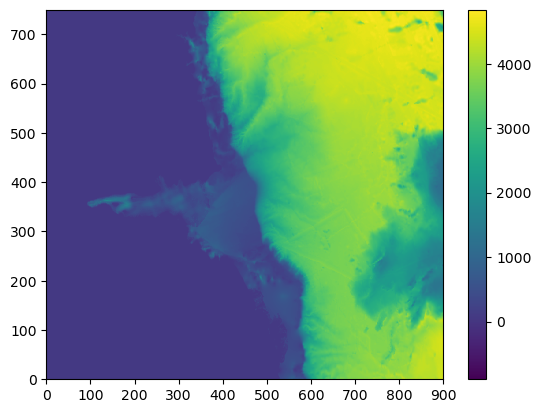

In [ ]:
plt.pcolormesh(grd3.h+grd3.zice)
plt.colorbar()
(grd3.h+grd3.zice).min()

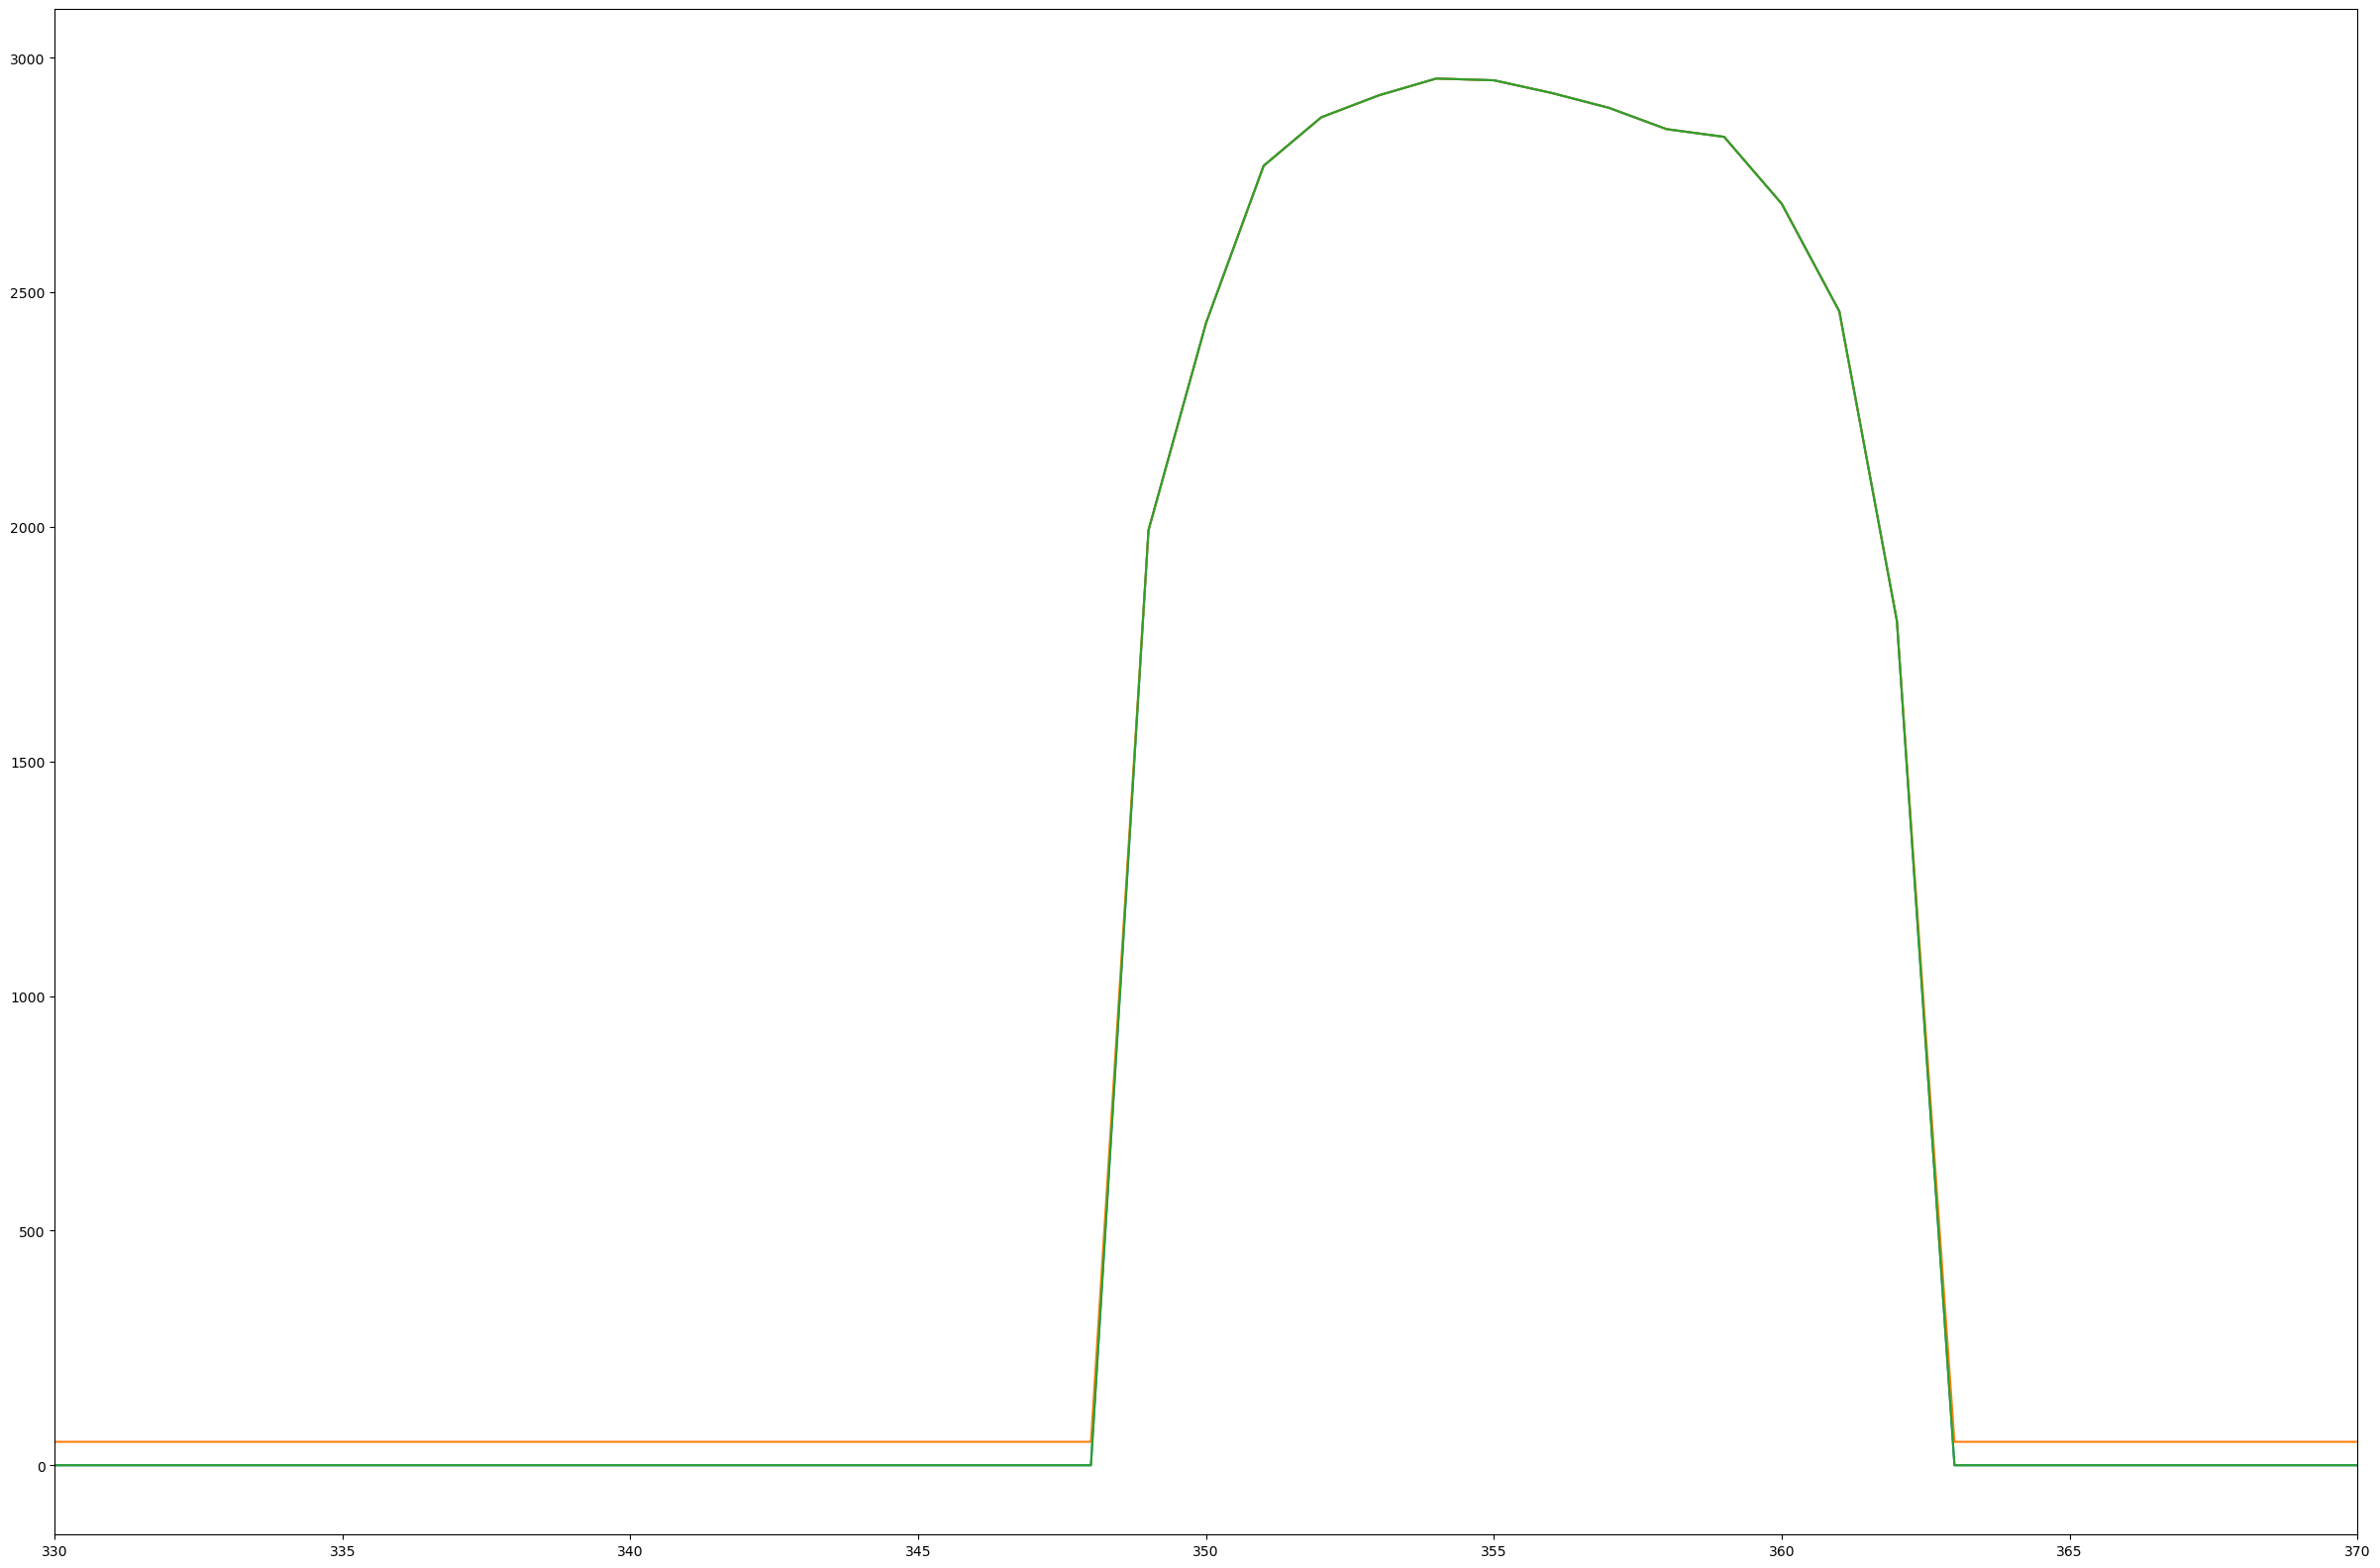

(330.0, 370.0)

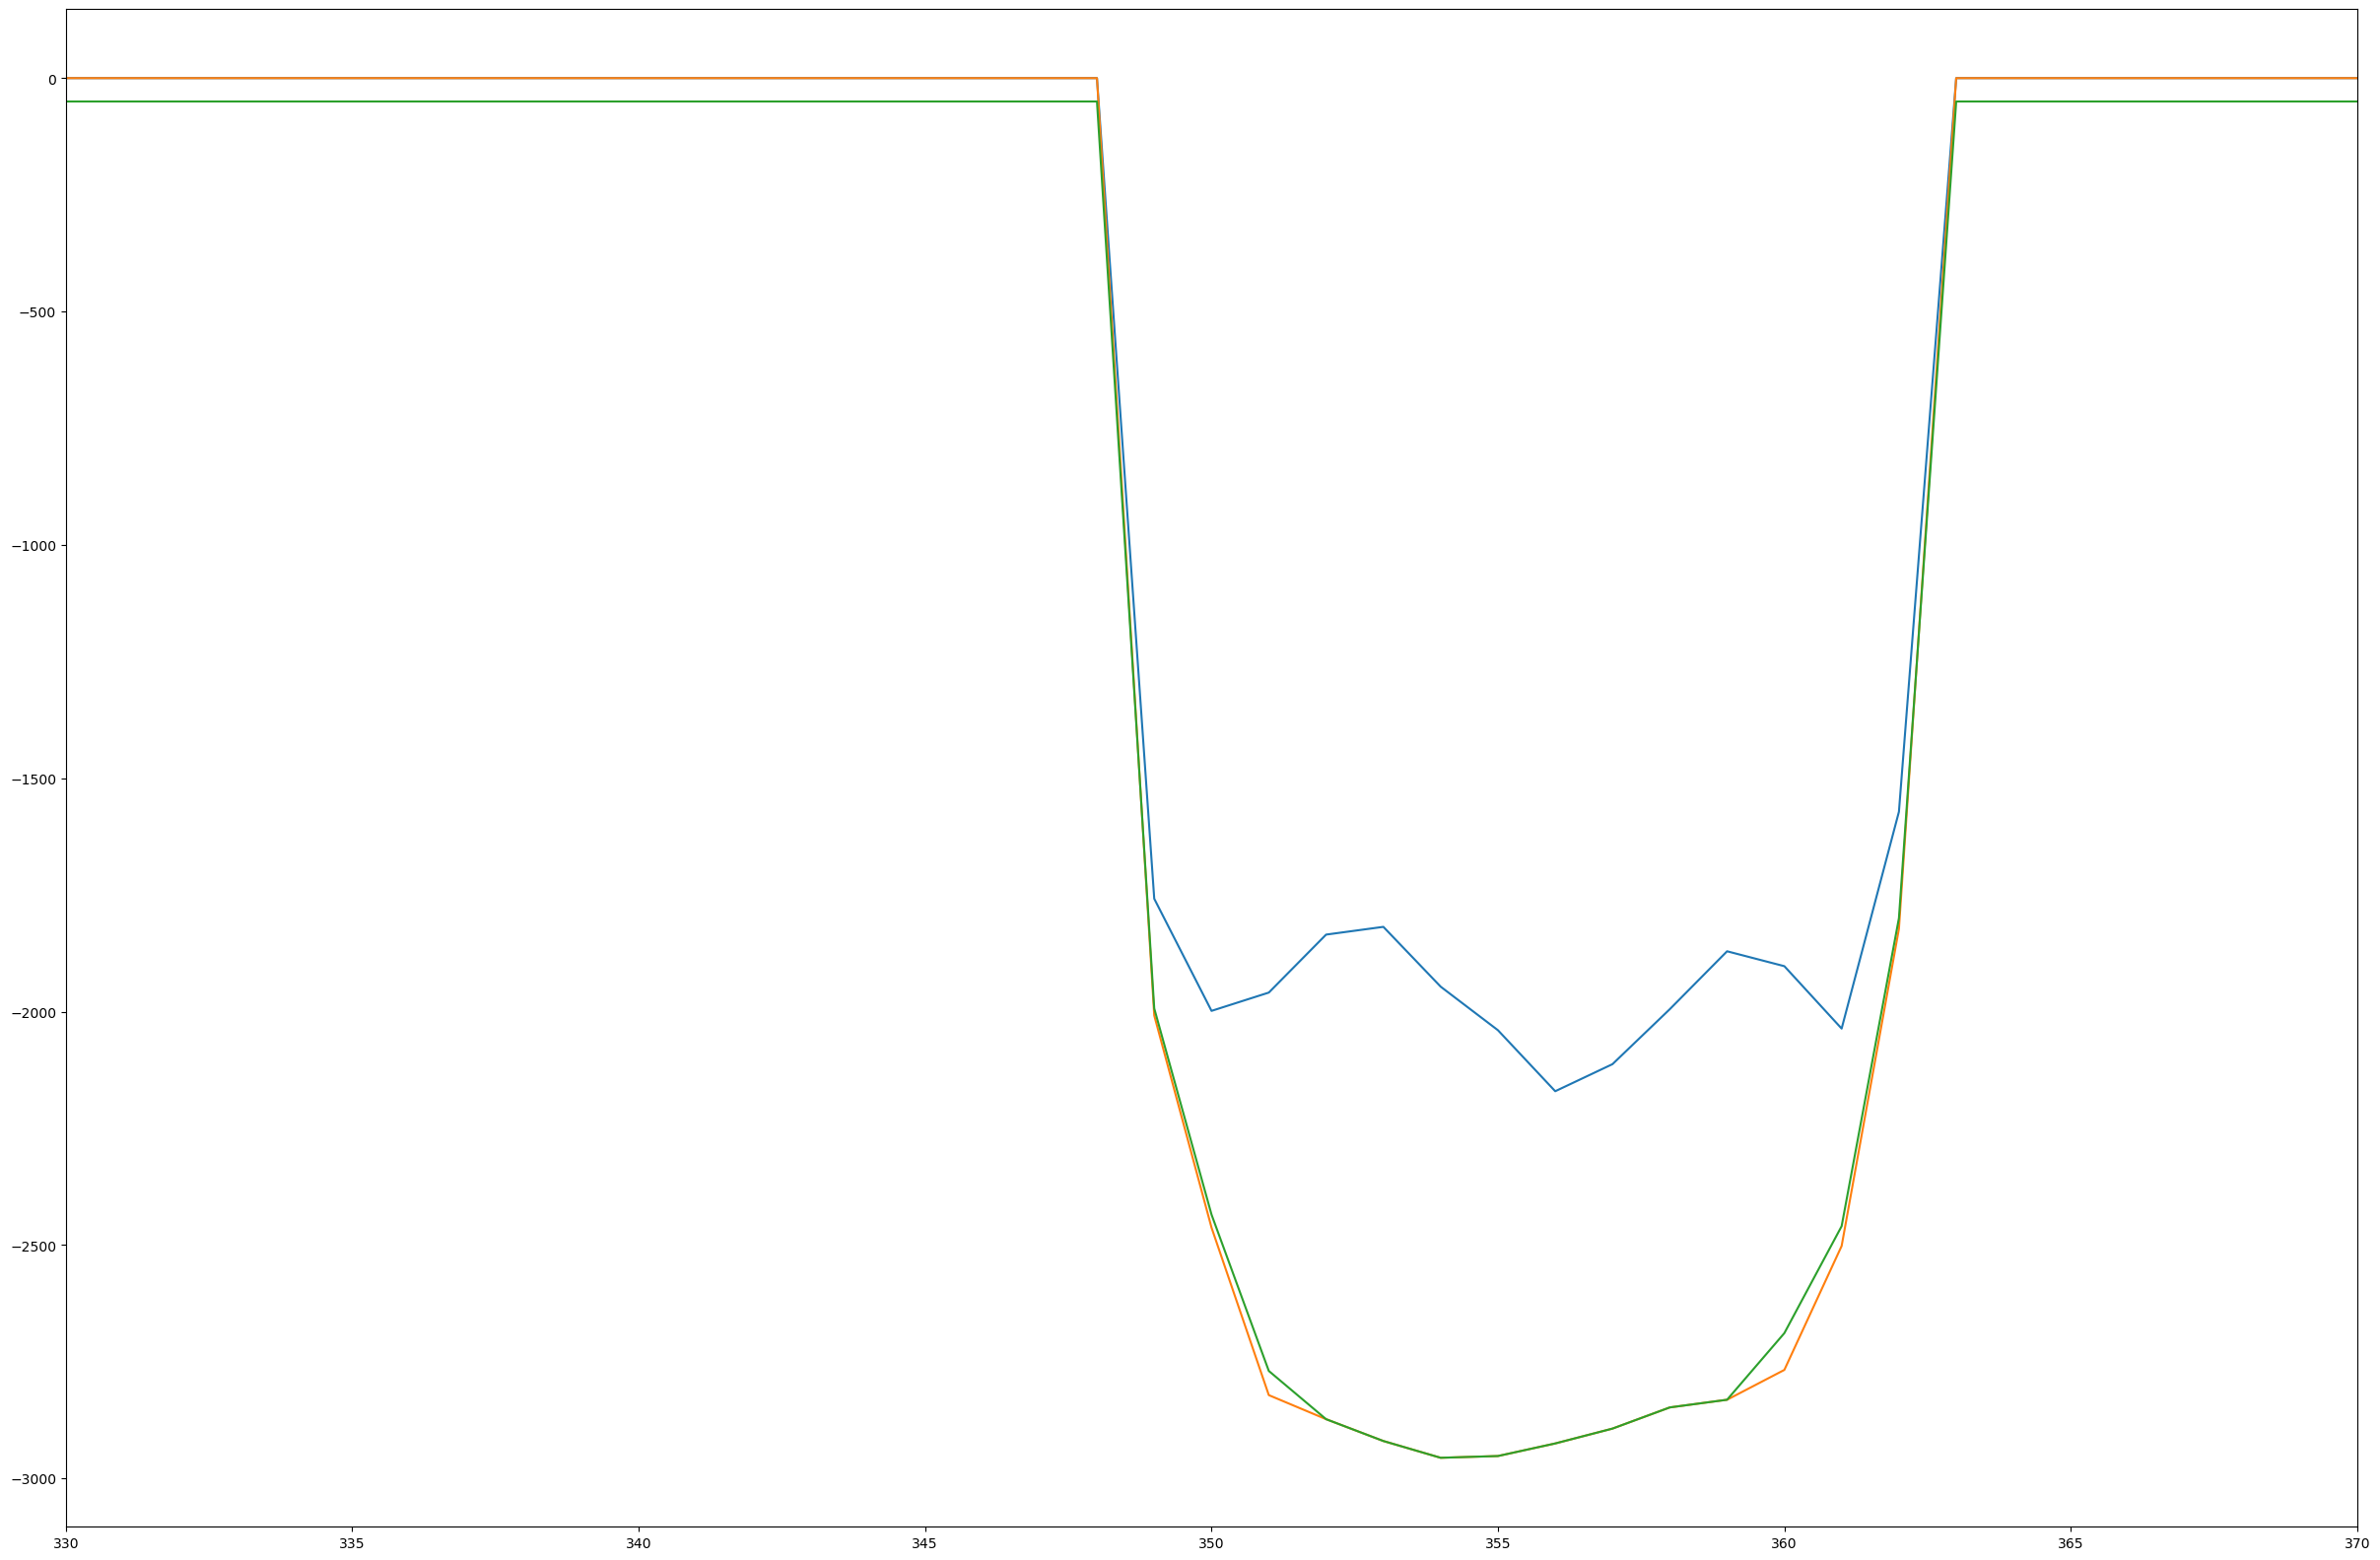

In [ ]:
plt.figure(figsize=(30,20))
# plt.pcolormesh((bed-grd3.h)*grd3.mask_rho)
# plt.colorbar()
# plt.xlim(100,140)
# plt.ylim(330,370)
plt.plot(bed[:,100])
plt.plot(grd3.h[:,100])
plt.plot(bed[:,100]*grd3.mask_rho[:,100])
plt.xlim(330,370)
plt.show()
plt.figure(figsize=(30,20))
plt.plot(grd3.zice[:,100])
plt.plot(-grd.h[:,100])
plt.plot(-grd3.h[:,100])

plt.xlim(330,370)



In [ ]:
TESTING STOP

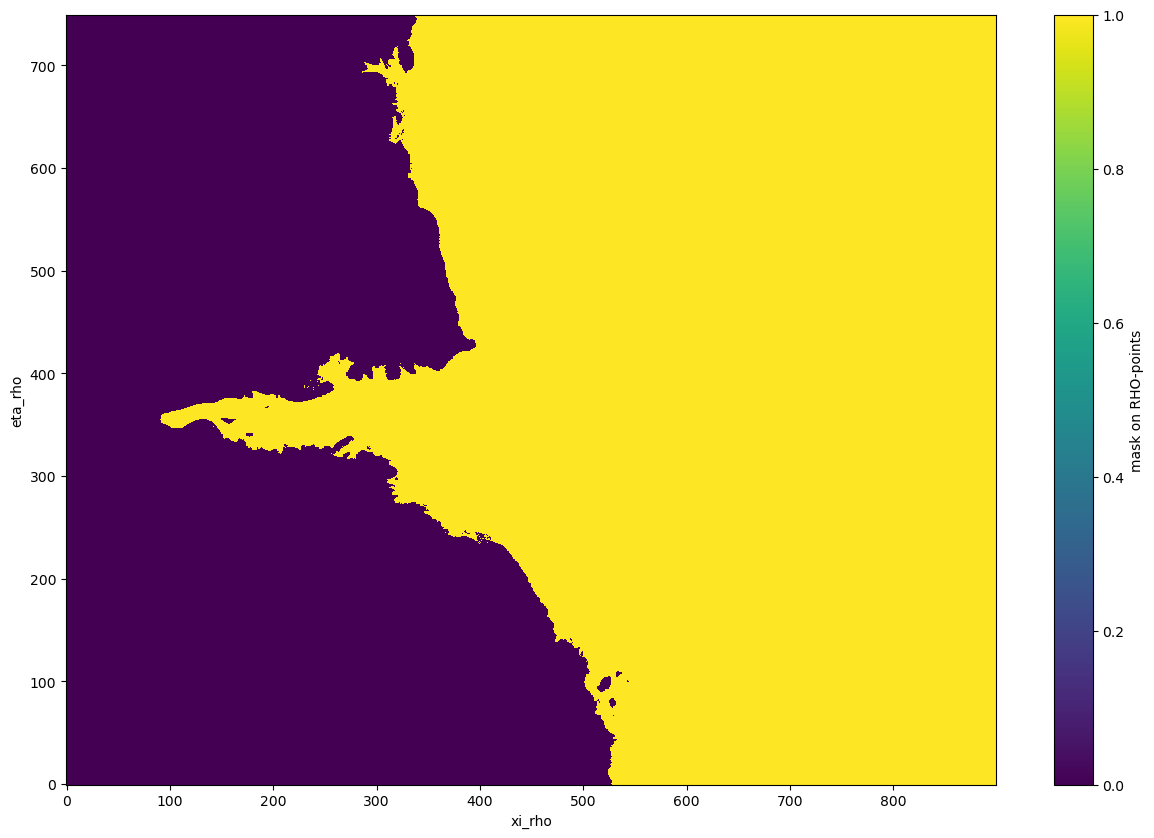

In [ ]:


plt.figure(figsize=(15,10))
grd2.mask_rho.plot()



In [ ]:
from contextlib import suppress

def compare_neighbors(arr):
# # test example:
# arr = np.array([[False, False, False, False, False, False],
#                 [False, True, False, True, False, False],
#                 [False, False, False, False, True, False],
#                 [True, False, False, True, True, False],
#                 [False, True, True, True, False, False],
#                 [False, True, False, True, False, False],
#                 [False, True, True, True, False, False]])

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # print(x,y)
        # print(x,y,arr.shape[0],arr.shape[1])
        # print((x<arr.shape[0]) & (y<arr.shape[1]))
        if (x>0) & (y>0) & (x<arr.shape[0]-1) & (y<arr.shape[1]-1):
            # print(x,y)
            if (arr[x-1, y] != item) & (arr[x+1, y] != item) & (arr[x, y+1] != item) & (arr[x, y-1] != item):
                if (arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item):
                    comp_arr[x, y] = True # Isolated cells are set to True
                if ((arr[x-1, y-1] == item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] == item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] == item) & (arr[x+1, y+1] != item)) |\
                    ((arr[x-1, y-1] != item) & (arr[x+1, y-1] != item) & (arr[x-1, y+1] != item) & (arr[x+1, y+1] == item)):
                    comp_arr[x, y] = True # find diagonal single cells
    return comp_arr

# # test example:
# arr = np.array([[False, False, False, False, False, False,False],
#                 [False, True, False, True, False, False,False],
#                 [False, False, False, False, True, False,False],
#                 [True, False, False, True, True, False,False],
#                 [False, True, True, True, False, False,False],
#                 [False, True, False, True, False, True,False],
#                 [False, True, True, True, False, False,True]])
# test = compare_neighbors(arr)
test = compare_neighbors(grd2.mask_rho)

print( test)



[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


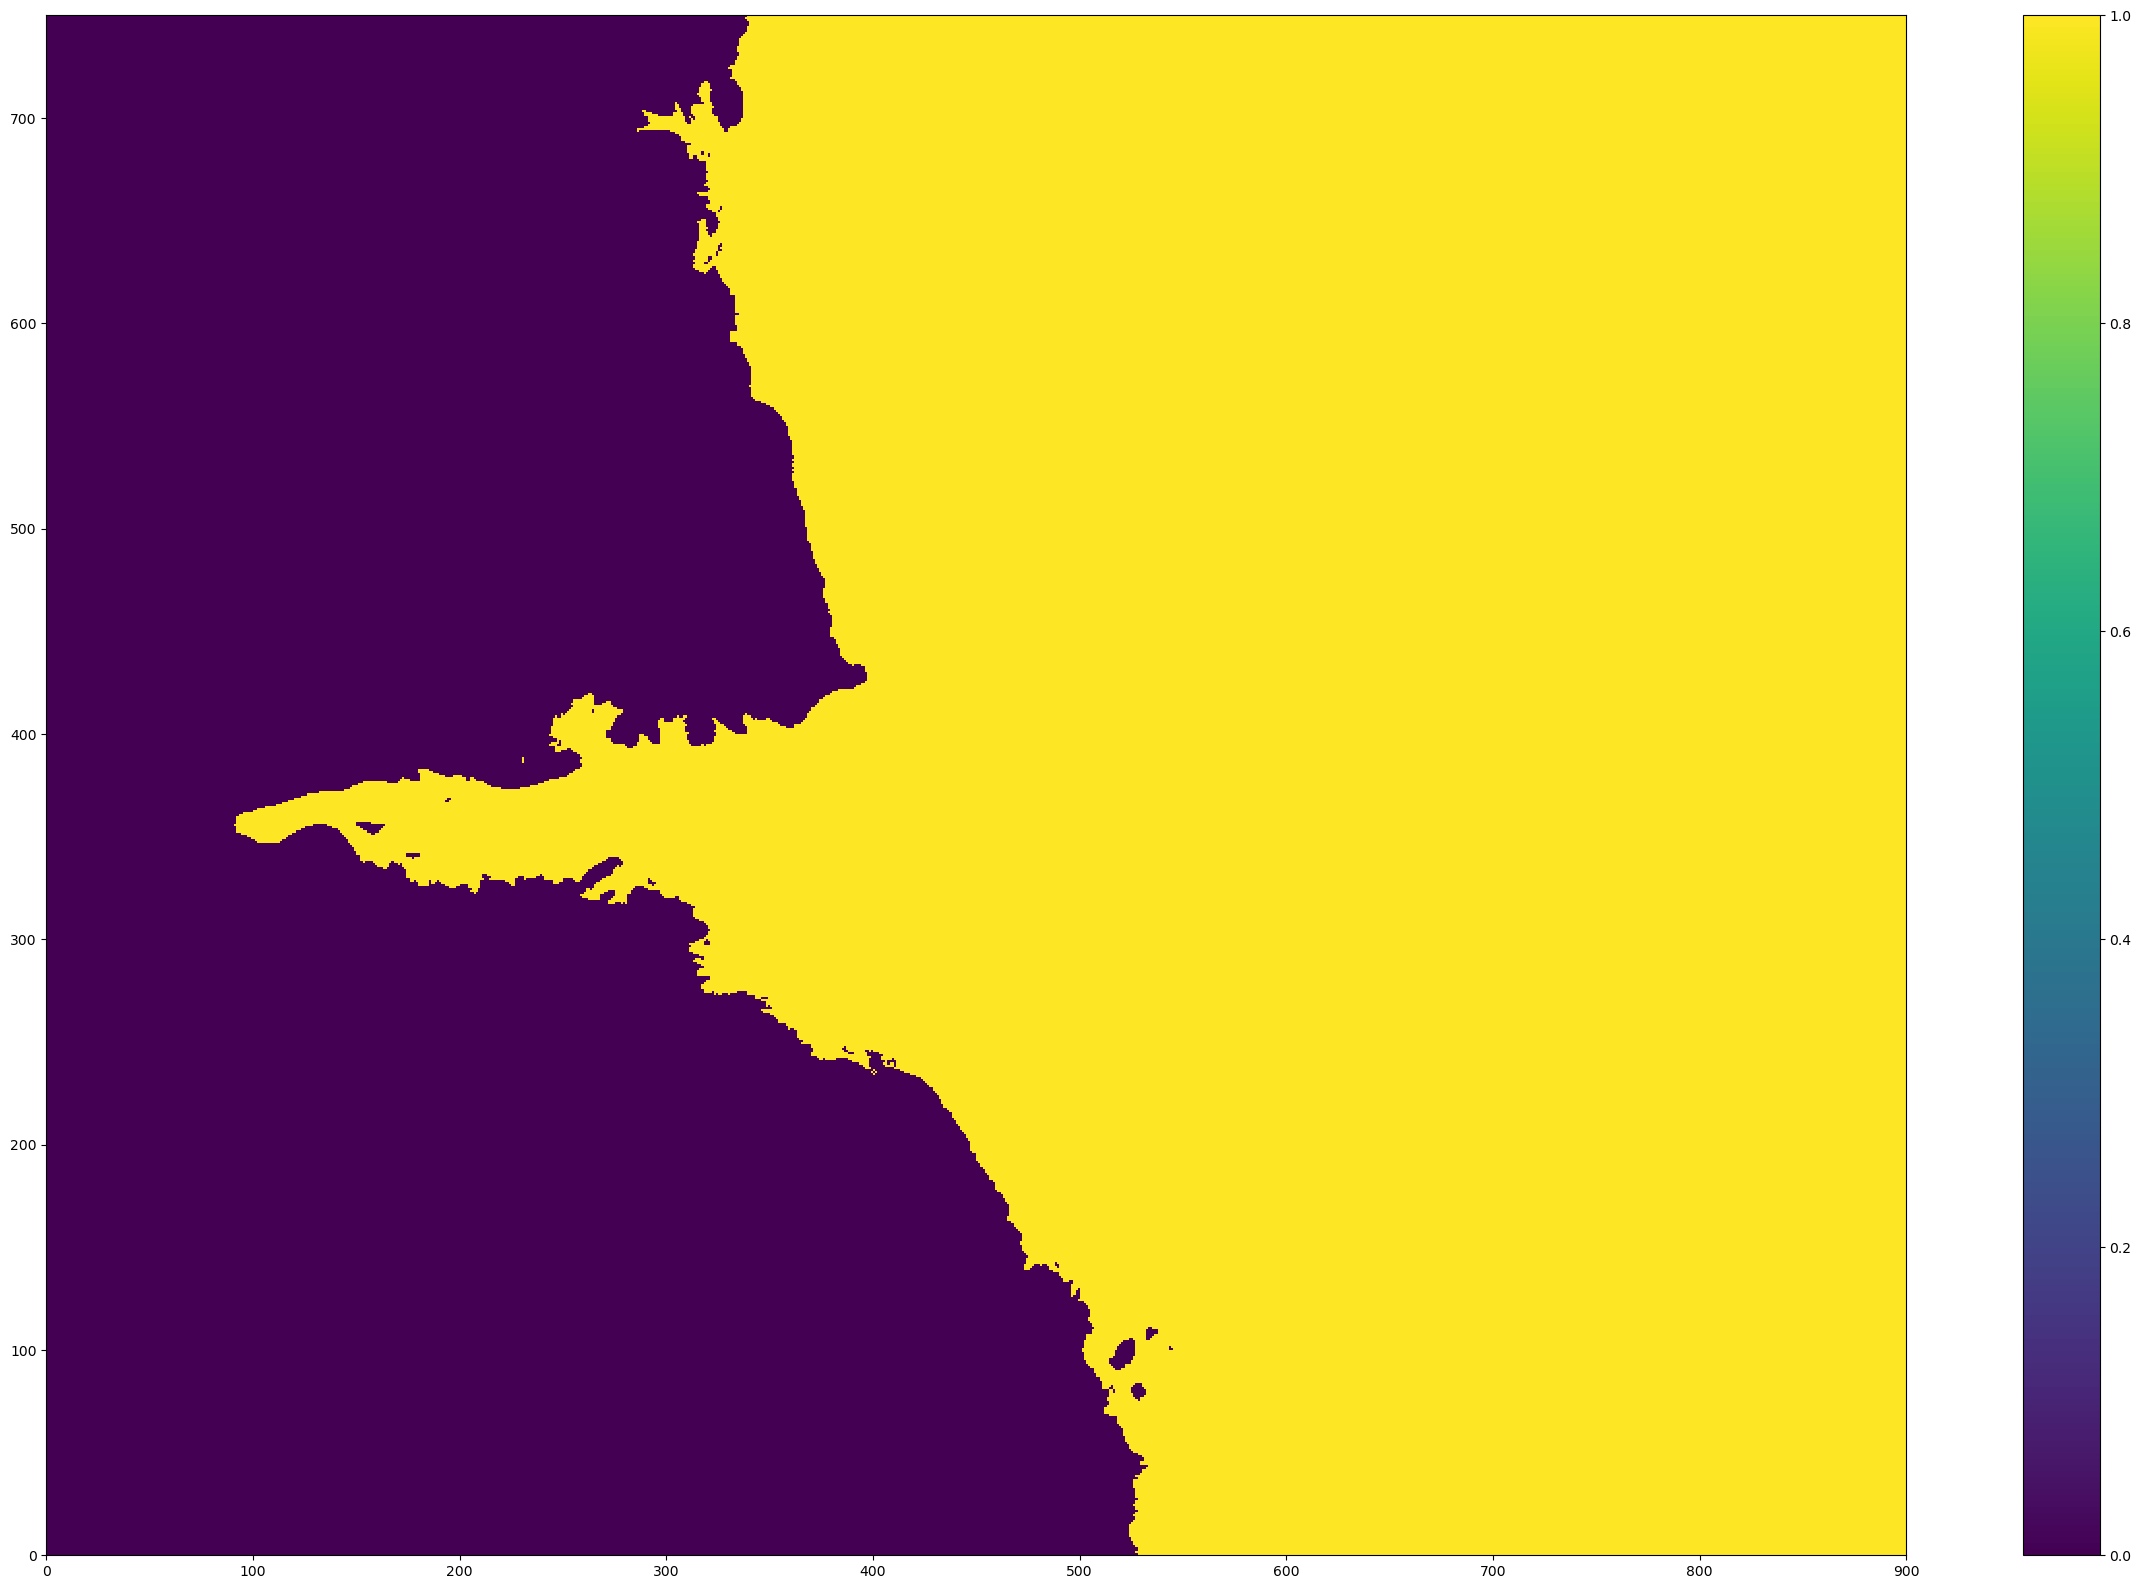

In [ ]:
new_mask = grd2.mask_rho.where(~test,np.logical_not(grd2.mask_rho))
plt.figure(figsize=(30,20))

plt.pcolormesh(new_mask)
plt.colorbar()

In [ ]:
plt.figure(figsize=(30,20))
plt.pcolormesh(grd2.mask_rho)
plt.contour(np.pad(test,1,mode='edge')*1.0,linewidths=0.5)
plt.colorbar()

In [ ]:


grd2.to_netcdf('/home/woden/Documents/amery-hires-setup/data/proc/amery_v2km_grd_v2.nc',unlimited_dims='bath')


In [ ]:
from pyroms.vgrid import s_coordinate
from pyroms.vgrid import s_coordinate_2
from pyroms.vgrid import s_coordinate_4
from pyroms.vgrid import z_r
from pyroms.vgrid import z_w

N=31
Vtransform=2
Vstretching=4
theta_s=1
theta_b=4
Tcline=50
hc=20
zeta=np.zeros_like(roms_tmp['bathy'])

if (Vtransform==2) & (Vstretching==4):
    grd_verts = s_coordinate_4(roms_tmp['bathy'],theta_b,theta_s,Tcline,N)
    # grd_z_r = z_r(roms_tmp['bathy'],hc,N,grd_verts.s_rho,grd_verts.Cs_r,np.zeros_like(roms_tmp['bathy']),Vtransform)
    # grd_z_w = z_w(roms_tmp['bathy'],hc,N+1,grd_verts.s_w,grd_verts.Cs_w,np.zeros_like(roms_tmp['bathy']),Vtransform)
    Cs_r_3 = (np.tile(grd_verts.Cs_r,[roms_tmp['bathy'].shape[0],roms_tmp['bathy'].shape[1],1]))
    S_rho_3 = (np.tile(grd_verts.s_rho,[roms_tmp['bathy'].shape[0],roms_tmp['bathy'].shape[1],1]))
    Cs_w_3 = (np.tile(grd_verts.Cs_w,[roms_tmp['bathy'].shape[0],roms_tmp['bathy'].shape[1],1]))
    S_w_3 = (np.tile(grd_verts.s_w,[roms_tmp['bathy'].shape[0],roms_tmp['bathy'].shape[1],1]))
    h_3 = (np.tile(roms_tmp['bathy'],[N,1,1])).transpose(1,2,0)
    h_w3 = (np.tile(roms_tmp['bathy'],[N+1,1,1])).transpose(1,2,0)
    zice_3 = (np.tile(roms_tmp['draft'],[N,1,1])).transpose(1,2,0)
    zice_w3 = (np.tile(roms_tmp['draft'],[N+1,1,1])).transpose(1,2,0)
  
    
    Zo_rho = (hc * S_rho_3 + Cs_r_3 * h_3) / (hc + h_3)
    z_rho = zice_3 + (zice_3 + h_3) * Zo_rho
    Zo_w = (hc * S_w_3 + Cs_w_3 * h_w3) / (hc + h_w3)
    z_w = Zo_w * (zice_w3 + h_w3) + zice_w3
    
    z_w = z_w.transpose(2,0,1)
    z_rho = z_rho.transpose(2,0,1)



In [ ]:
import numpy as np

def rx0(h,rmask):
    """
    function rx0 = rx0(h,rmask)
 
    This function computes the bathymetry slope from a SCRUM NetCDF file.

    On Input:
       h           bathymetry at RHO-points.
       rmask       Land/Sea masking at RHO-points.
 
    On Output:
       rx0         Beckmann and Haidvogel grid stiffness ratios.
    """

    Mp, Lp = h.shape
    L=Lp-1
    M=Mp-1

    #  Land/Sea mask on U-points.
    umask = np.zeros((Mp,L))
    for j in range(Mp):
        for i in range(1,Lp):
            umask[j,i-1] = rmask[j,i] * rmask[j,i-1]

    #  Land/Sea mask on V-points.
    vmask = np.zeros((M,Lp))
    for j in range(1,Mp):
        for i in range(Lp):
            vmask[j-1,i] = rmask[j,i] * rmask[j-1,i]

    #-------------------------------------------------------------------
    #  Compute R-factor.
    #-------------------------------------------------------------------

    hx = np.zeros((Mp,L))
    hy = np.zeros((M,Lp))

    hx = abs(h[:,1:] - h[:,:-1]) / (h[:,1:] + h[:,:-1])
    hy = abs(h[1:,:] - h[:-1,:]) / (h[1:,:] + h[:-1,:])

    hx = hx * umask
    hy = hy * vmask

    rx0 = np.maximum(np.maximum(hx[:-1,:],hx[1:,:]),np.maximum(hy[:,:-1],hy[:,1:]))

    rmin = rx0.min()
    rmax = rx0.max()
    ravg = rx0.mean()
    rmed = np.median(rx0)

    print('  ')
    print('Minimum r-value = ', rmin)
    print('Maximum r-value = ', rmax)
    print('Mean    r-value = ', ravg)
    print('Median  r-value = ', rmed)

    return rx0

In [ ]:
import numpy as np

def rx1(z_w,rmask):
    """
    function rx1 = rx1(z_w,rmask)
 
    This function computes the bathymetry slope from a SCRUM NetCDF file.

    On Input:
       z_w         layer depth.
       rmask       Land/Sea masking at RHO-points.
 
    On Output:
       rx1         Haney stiffness ratios.
    """

    N, Lp, Mp = z_w.shape
    L=Lp-1
    M=Mp-1

    #  Land/Sea mask on U-points.
    umask = np.zeros((L,Mp))
    for j in range(Mp):
        for i in range(1,Lp):
            umask[i-1,j] = rmask[i,j] * rmask[i-1,j]

    #  Land/Sea mask on V-points.
    vmask = np.zeros((Lp,M))
    for j in range(1,Mp):
        for i in range(Lp):
            vmask[i,j-1] = rmask[i,j] * rmask[i,j-1]

    #-------------------------------------------------------------------
    #  Compute R-factor.
    #-------------------------------------------------------------------

    zx = np.zeros((N,L,Mp))
    zy = np.zeros((N,Lp,M))

    for k in range(N):
        zx[k,:] = abs((z_w[k,1:,:] - z_w[k,:-1,:] + z_w[k-1,1:,:] - z_w[k-1,:-1,:]) / 
                      (z_w[k,1:,:] + z_w[k,:-1,:] - z_w[k-1,1:,:] - z_w[k-1,:-1,:]))
        zy[k,:] = abs((z_w[k,:,1:] - z_w[k,:,:-1] + z_w[k-1,:,1:] - z_w[k-1,:,:-1]) /
                      (z_w[k,:,1:] + z_w[k,:,:-1] - z_w[k-1,:,1:] - z_w[k-1,:,:-1]))
        zx[k,:] = zx[k,:] * umask
        zy[k,:] = zy[k,:] * vmask


    r = np.maximum(np.maximum(zx[:,:,:-1],zx[:,:,1:]), np.maximum(zy[:,:-1,:],zy[:,1:,:]))

    rx1 = np.amax(r, axis=0)

    rmin = rx1.min()
    rmax = rx1.max()
    ravg = rx1.mean()
    rmed = np.median(rx1)

    print('  ')
    print('Minimum r-value = ', rmin)
    print('Maximum r-value = ', rmax)
    print('Mean    r-value = ', ravg)
    print('Median  r-value = ', rmed)

    return rx1